In [1]:
import cupy as cp
from cupyx import scatter_add
import cupyx.scipy.sparse.linalg
import cupyx.scipy.sparse as cusparse
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from includes.preprocessor import write_keywords,write_birth,write_parameters
from includes.gamma import domain_mgr, heat_solve_mgr,load_toolpath,get_toolpath
%matplotlib notebook
cp.cuda.Device(1).use()
!nvidia-smi
import pyvista as pv
from pyvirtualdisplay import Display
import vtk

Tue Jun  1 13:25:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:01:00.0 Off |                  Off |
| 69%   84C    P2   206W / 260W |  11220MiB / 48598MiB |     91%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:21:00.0 Off |                  Off |
| 33%   

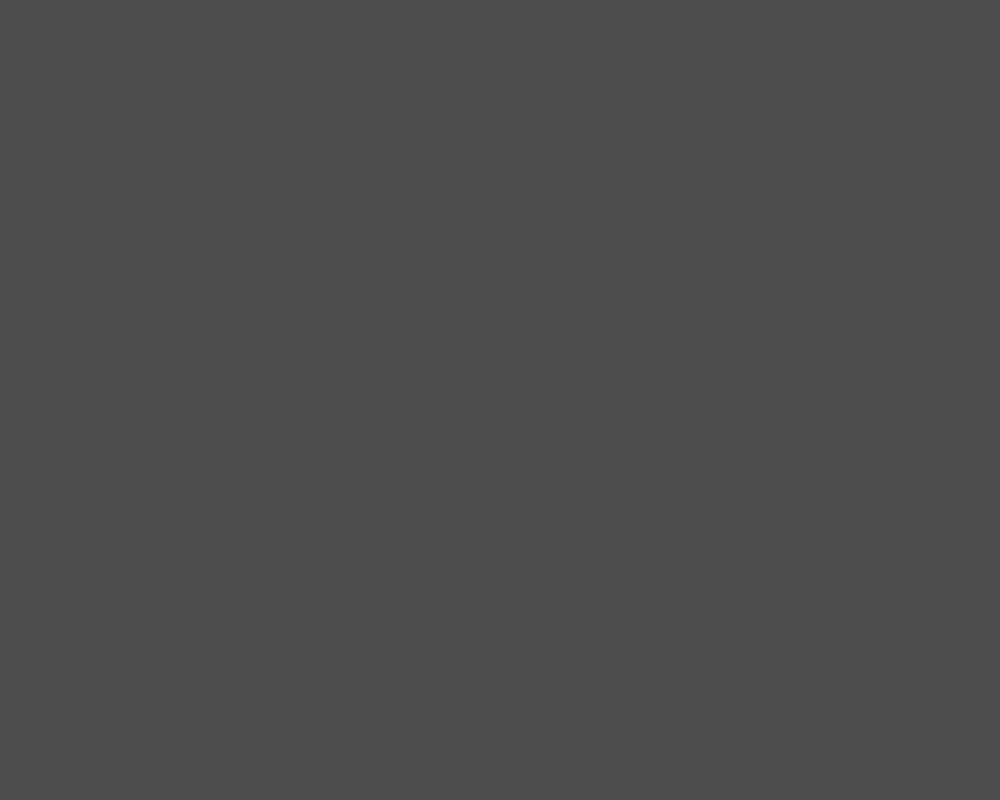

Time of reading input files: 33.883360385894775
Time of calculating critical timestep: 0.3404245376586914
Time of reading and interpolating toolpath: 0.14814352989196777
Number of nodes: 122825
Number of elements: 98176
Number of time-steps: 201618
Time of generating surface: 208.15817379951477


In [2]:
file_name = 'input_files/cylinder.inp'
output_file = 'input_files/cylinder.k'
toolpath_file = 'input_files/cylinder_toolpath.crs'
height = 15
radius = 1
# smaller than element size, e.g half of the element size, same unit
path_resolution = 0.1
write_keywords(file_name,output_file,height)
write_birth(output_file,toolpath_file,path_resolution,radius,gif_end=200,nFrame=100)
write_parameters(output_file)
domain = domain_mgr(filename='input_files/cylinder.k',toolpath_file='input_files/cylinder_toolpath.crs')

In [3]:
def elastic_stiff_matrix(elements, nodes, shear_0, bulk_0):
    n_n = nodes.shape[0]
    n_e = elements.shape[0]
    n_p = elements.shape[1]
    n_q = 8
    n_int = n_e*n_q
    nodes_pos = nodes[elements]
    Jac = cp.matmul(domain.Bip_ele,nodes_pos[:,cp.newaxis,:,:].repeat(8,axis=1)) # J = B*x [B:8(nGP)*3(dim)*8(nN), x:nE*8*8*3]
    ele_detJac = cp.linalg.det(Jac)
    iJac = cp.linalg.inv(Jac) #inv J (nE*nGp*dim*dim)
    ele_gradN = cp.matmul(iJac,domain.Bip_ele) # dN/dx = inv(J)*B

    ele_B = cp.zeros([n_e,n_q,6,n_p*3])
    ele_B[:,:,0,0:24:3] = ele_gradN[:,:,0,:]
    ele_B[:,:,1,1:24:3] = ele_gradN[:,:,1,:]
    ele_B[:,:,2,2:24:3] = ele_gradN[:,:,2,:]
    ele_B[:,:,3,0:24:3] = ele_gradN[:,:,1,:]
    ele_B[:,:,3,1:24:3] = ele_gradN[:,:,0,:]
    ele_B[:,:,4,1:24:3] = ele_gradN[:,:,2,:]
    ele_B[:,:,4,2:24:3] = ele_gradN[:,:,1,:]
    ele_B[:,:,5,2:24:3] = ele_gradN[:,:,0,:]
    ele_B[:,:,5,0:24:3] = ele_gradN[:,:,2,:]

    temp = cp.array([[0,1,2]]).repeat(n_p,axis=0).flatten()
    jB = 3*cp.tile(elements[:,cp.newaxis,cp.newaxis,:],(1,n_q,6,1)).repeat(3,axis=3) + temp
    vB = ele_B.reshape(-1,n_p*3)
    jB = jB.reshape(-1,n_p*3)
    iB = cp.arange(0,jB.shape[0])[:,cp.newaxis].repeat(n_p*3,axis=1)
    B = cusparse.csr_matrix((cp.ndarray.flatten(vB),(cp.ndarray.flatten(iB), cp.ndarray.flatten(jB))), shape = (6*n_int, 3*n_n), dtype = cp.float)

    IOTA = cp.array([[1],[1],[1],[0],[0],[0]]) 
    VOL = cp.matmul(IOTA,IOTA.transpose()) 
    DEV = cp.diag([1,1,1,1/2,1/2,1/2])-VOL/3

    ELASTC = 2*DEV*shear_0 + VOL*bulk_0
    ele_D = ele_detJac[:,:,cp.newaxis,cp.newaxis]*ELASTC
    temp = cp.arange(0,n_e*n_q*6).reshape(n_e,n_q,6)
    iD = temp[:,:,cp.newaxis,:].repeat(6,axis = 2)
    jD = temp[:,:,:,cp.newaxis].repeat(6,axis = 3)

    D = cusparse.csr_matrix((cp.ndarray.flatten(ele_D),(cp.ndarray.flatten(iD), cp.ndarray.flatten(jD))), shape = (6*n_int, 6*n_int), dtype = cp.float)
    ele_K =  ele_B.transpose([0,1,3,2])@ele_D@ele_B
    ele_K = ele_K.sum(axis = 1)

#     temp = cp.array([[0,1,2]]).repeat(n_p,axis=0).flatten()[:,cp.newaxis]
#     iK = 3*elements[:,:,cp.newaxis].repeat(3,axis=1) + temp
#     iK = iK.repeat(3*n_p,axis=2)
#     jK = 3*elements[:,cp.newaxis,:].repeat(3,axis=2) + temp.transpose()
#     jK = jK.repeat(3*n_p,axis=1)
#     K  = cusparse.csr_matrix((cp.ndarray.flatten(ele_K),(cp.ndarray.flatten(iK),cp.ndarray.flatten(jK))), shape = (3*n_n, 3*n_n), dtype = cp.float)
    K = B.transpose()*D*B 
    return K,B,D,ele_B,ele_D,iD,jD,ele_detJac

def constitutive_problem(E, Ep_prev, Hard_prev, shear_0, bulk_0, a_0, Y):
    IOTA = cp.array([[1],[1],[1],[0],[0],[0]])  
    VOL = cp.matmul(IOTA,IOTA.transpose()) 
    DEV = cp.diag([1,1,1,1/2,1/2,1/2])-VOL/3
    E_tr = E-Ep_prev  
    ELASTC = 2*DEV*shear_0 + VOL*bulk_0
    S_tr = (ELASTC @ E_tr[:,:,:,cp.newaxis]).squeeze()
    SD_tr = (2*DEV*shear_0@E_tr[:,:,:,cp.newaxis]).squeeze() - Hard_prev
    norm_SD = cp.sqrt(cp.sum(SD_tr[:,:,0:3]*SD_tr[:,:,0:3], axis=2)+2*cp.sum(SD_tr[:,:,3:6]*SD_tr[:,:,3:6], axis=2))

    CRIT = norm_SD-Y
    IND_p = CRIT>0 

    S = cp.array(S_tr)
    DS = cp.ones((S.shape[0],S.shape[1],6,6))*ELASTC

    if not IND_p[IND_p].shape[0]:
        Ep = cp.array(Ep_prev)
        Hard = cp.array(Hard_prev)
        return S, DS, IND_p, Ep, Hard   
        
    N_hat = SD_tr[IND_p]/norm_SD[IND_p][:,cp.newaxis].repeat(6,axis=1)  
    denom =  2*shear_0 + a_0 
    Lambda = CRIT[IND_p]/denom

    S[IND_p] = S[IND_p] - 2*N_hat*shear_0*Lambda[:,cp.newaxis].repeat(6,axis=1)  
    NN_hat = N_hat[:,:,cp.newaxis]@N_hat[:,cp.newaxis,:]
    const = 4*shear_0**2/denom

    DS[IND_p] = DS[IND_p] - const*DEV + (const*Y[IND_p]/norm_SD[IND_p])[:,cp.newaxis,cp.newaxis].repeat(6,axis=1).repeat(6,axis=2)*(DEV-NN_hat)


    Ep = cp.array(Ep_prev)
    Ep[IND_p] = Ep[IND_p]+cp.matmul(cp.array([[1],[1],[1],[2],[2],[2]]),Lambda[cp.newaxis]).transpose()*N_hat

    Hard = cp.array(Hard_prev)
    Hard[IND_p] = Hard[IND_p]+(a_0*Lambda[:,cp.newaxis].repeat(6,axis=1))*N_hat
    
    return S, DS, IND_p, Ep, Hard

In [13]:
nodes = domain.nodes
elements = domain.elements
n_n = len(domain.nodes)
n_e = len(domain.elements)
n_p = 8
n_q = 8
n_int = n_e * n_q 
HatP = domain.Nip_ele.transpose()     # HatP   - values of basis functions at the quadrature points,
                                                          # size(HatP)=(n_p,n_q)
DHatP1 = domain.Bip_ele[:,0,:].transpose()        # DHatP1 - derivatives of basis functions at the quadrature points 
                                                          #  in the direction xi_1, size(DHatP1)=(n_p,n_q)
DHatP2 = domain.Bip_ele[:,1,:].transpose()       # DHatP2 - derivatives of basis functions at the quadrature points 
                                                          #  in the direction xi_2, size(DHatP2)=(n_p,n_q)
DHatP3 = domain.Bip_ele[:,2,:].transpose()         # DHatP3 - derivatives of basis functions at the quadrature points 
                                                          #  in the direction xi_3, size(DHatP3)=(n_p,n_q)
                                                          # n_p    - number of basis functions
                                                          # n_q    - number of integration points within one elemen

# values of elastic material parameters
#young = 206900                        # Young's modulus in MPa
young = 116888                         # Young's modulus at average temperature
poisson =  0.32                        # Poisson's ratio
shear_0 = young/(2*(1+poisson))        # shear modulus
bulk_0 = young/(3*(1-2*poisson))       # bulk modulus
# plastic material parematers
#a_0 = 10000
a_0 = 9500                             # Kinematic hardening parameter
#Y_0 = 450*np.sqrt(2/3)                # Yield stress in MPa
Y_0 = 744                              # Note that this is actually yield stress * sqrt(2/3)
T_Ref = 400                            # Reference or Ambient Temparature, always equal to 300 if specified otherwise
#T_Ref = 252                           # Reference or Ambient Temparature, always equal to 300 if specified otherwise
# Tolerence for Newton stopping criterion
tol = 1.0e-8                           # non-dimensionalized tolerence 
# Maximum Number of N_R Iterations allowed
Maxit = 150

# Initialization for the whole boundary-value problem
E = cp.zeros((n_e,n_q,6))                        # strain tensors at integration points
Ep_prev = cp.zeros((n_e,n_q,6))                  # plastic strain tensors at integration points
Hard_prev = cp.zeros((n_e,n_q,6))
Y = Y_0 * cp.ones((n_e,n_q))
U = cp.zeros((n_n,3))
dU = cp.zeros((n_n,3))
F = cp.zeros((n_n,3))
f = cp.zeros((n_n,3))                          
scl = 1.14875854e-05                           # average thermal expansion coefficient for Ti64A              
alpha_Th = cp.array([scl,scl,scl,0,0,0])
idirich = cp.array(nodes[:, 2] == -15.0 ) 

In [14]:
domain.dt*15

0.07095833673657888

In [15]:
%%time
heat_solver = heat_solve_mgr(domain)
heat_solver.height = 15
domain.current_time = 0
endtime = 1000
timestep = int(endtime/domain.dt)+1
# timestep = 1
heat_solver.q_in = 200
file_num = 0

layer_time = [32.9255,64.8510,96.7765,128.7020,160.6275,192.5530,224.4785,256.4040,288.3295,320.2550,
              352.1805,384.1060,416.0310,447.9570,479.8825,511.8080,543.7335,575.6590,607.5845,639.510,
             671.4355,703.3610,735.2865,767.2120,799.1375,831.0630,862.9885,894.9140,926.8395,9999]
# layer_time = [2.5,4.5,6.5,8.5,10.5,12.5,14.5,16.5,18.5,99999]
layer = 0
n_e_active = sum(domain.element_birth < layer_time[layer])
n_n_active = sum(domain.node_birth < layer_time[layer])
active_eles = elements[0:n_e_active]
active_nodes = nodes[0:n_n_active]
Q = cp.zeros(nodes.shape, dtype=bool)
Q[0:n_n_active,:] = 1 
Q[idirich,:] = 0 
K_elast,B,D_elast,ele_B,ele_D,iD,jD,ele_detJac = elastic_stiff_matrix(active_eles,active_nodes, shear_0, bulk_0)

for t in range(0,timestep):
    if t % 5000 == 0:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
        print("Current time:  {}, Percentage done:  {}%".format(domain.current_time,100*t/timestep))  
    heat_solver.time_integration()
    
    if t % 15 == 0:
        if domain.current_time>layer_time[layer]:
            layer = layer + 1
            U = disp_match(nodes,U,layer)
            n_e_active = sum(domain.element_birth < layer_time[layer])
            n_n_active = sum(domain.node_birth < layer_time[layer])
            active_eles = elements[0:n_e_active]
            active_nodes = nodes[0:n_n_active]
            Q = cp.zeros(nodes.shape, dtype=bool)
            Q[0:n_n_active,:] = 1 
            Q[idirich,:] = 0 
            K_elast,B,D_elast,ele_B,ele_D,iD,jD,ele_detJac = elastic_stiff_matrix(active_eles,active_nodes, shear_0, bulk_0)
# cut off temp
        temperature_nodes = cp.clip(heat_solver.temperature[elements[0:n_e_active]],300,2300) - 300
        temperature_ip = (domain.Nip_ele[:,cp.newaxis,:]@temperature_nodes[:,cp.newaxis,:,cp.newaxis].repeat(8,axis=1))[:,:,0,0]
        it = 0
        U_it = U[0:n_n_active,:]
        while True:
            #E[0:n_e_active] = (ele_B@(U[active_eles].reshape(-1,24))[:,cp.newaxis,:,cp.newaxis].repeat(n_q,axis=1)).squeeze()
            E[0:n_e_active] = cp.reshape(B@U_it.flatten(),(-1,8,6))
            E[0:n_e_active] = E[0:n_e_active] - temperature_ip[:,:,cp.newaxis].repeat(6,axis=2)*alpha_Th
            
            S, DS, IND_p,_,_ = constitutive_problem(E[0:n_e_active], Ep_prev[0:n_e_active], Hard_prev[0:n_e_active], shear_0, bulk_0, a_0, Y[0:n_e_active])
            vD = ele_detJac[:,:,cp.newaxis,cp.newaxis].repeat(6,axis=2).repeat(6,axis=3) * DS
            D_p = cusparse.csr_matrix((cp.ndarray.flatten(vD), (cp.ndarray.flatten(iD),cp.ndarray.flatten(jD))), shape = D_elast.shape, dtype = cp.float)
            K_tangent = K_elast + B.transpose()*(D_p-D_elast)*B
            n_plast = len(IND_p[IND_p])
            print(' plastic integration points: ', n_plast, ' of ', IND_p.shape[0]*IND_p.shape[1])
            F = B.transpose() @ ((ele_detJac[:,:,cp.newaxis].repeat(6,axis=2)*S).reshape(-1))
            dU[Q,:],error = cusparse.linalg.cg(K_tangent[Q[0:n_n_active].flatten()][:,Q[0:n_n_active].flatten()],-F[Q[0:n_n_active].flatten()],tol=tol)
#            dU,error = cusparse.linalg.cg(K_tangent,-F,tol=tol)
            U_new = U_it + dU[0:n_n_active,:] 
#            U_new[0:n_n_active] = U_new[0:n_n_active] + dU.reshape(-1,3)
            q1 = dU[0:n_n_active].flatten()@K_elast@dU[0:n_n_active].flatten()
            q2 = U[0:n_n_active].flatten()@K_elast@U[0:n_n_active].flatten()
            q3 = U_new[0:n_n_active].flatten()@K_elast@U_new[0:n_n_active].flatten()
            if q2 == 0 and q3 == 0:
                criterion = 0
            else:
                criterion = q1/(q2+q3)
                print('  stopping criterion=  ', criterion)

            U_it = cp.array(U_new) 
            # test on the stopping criterion
            if  criterion < tol:
                break
                
            # test on number of iteration
            it = it+1
            if  it > Maxit:
                raise Exception('The Newton solver does not converge for the current timestep: {}'.format(t))
        U[0:n_n_active] = U_it        
        E[0:n_e_active] = (ele_B@(U[active_eles].reshape(-1,24))[:,cp.newaxis,:,cp.newaxis].repeat(n_q,axis=1)).squeeze()
        E[0:n_e_active] = E[0:n_e_active] - temperature_ip[:,:,cp.newaxis].repeat(6,axis=2)*alpha_Th
            
        S, DS, IND_p,Ep,Hard = constitutive_problem(E[0:n_e_active], Ep_prev[0:n_e_active], Hard_prev[0:n_e_active], shear_0, bulk_0, a_0, Y[0:n_e_active])

        Ep_prev[0:n_e_active] = Ep
        Hard_prev[0:n_e_active] = Hard
        
        if t%300 == 0:
            filename = 'residual_stress/cylinder/cylinder_{}.vtk'.format(file_num)
            save_vtk(filename)
            filename = 'residual_stress/cylinder_v2/cylinder_{}.vtk'.format(file_num)
            save_vtk2(filename)
            file_num = file_num + 1

Current time:  0, Percentage done:  0.0%
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
 plastic integration points:  0  of  117248
  stopping criterion=   1.0
 plastic integration points:  71  of  117248
  stopping criterion=   0.0002457247191166104
 plastic integration points:  73  of  117248
  stopping criterion=   8.464926382979255e-07
 plastic integration points:  73  of  117248


  stopping criterion=   2.065258173659807e-08
 plastic integration points:  163  of  117248
  stopping criterion=   2.7825163492900536e-15
 plastic integration points:  73  of  117248
  stopping criterion=   0.02298957784494551
 plastic integration points:  155  of  117248
  stopping criterion=   3.750784863627028e-05
 plastic integration points:  167  of  117248
  stopping criterion=   1.7810973354756692e-07
 plastic integration points:  167  of  117248
  stopping criterion=   7.299316758442676e-13
 plastic integration points:  60  of  117248
  stopping criterion=   0.027748595637309883
 plastic integration points:  152  of  117248
  stopping criterion=   7.89189438708719e-05
 plastic integration points:  155  of  117248
  stopping criterion=   3.5873323039542923e-07
 plastic integration points:  156  of  117248
  stopping criterion=   4.736626748282243e-11
 plastic integration points:  69  of  117248
  stopping criterion=   0.027978138840553047
 plastic integration points:  150  of  

 plastic integration points:  84  of  117248
  stopping criterion=   0.019332223831994583
 plastic integration points:  199  of  117248
  stopping criterion=   7.478078162533371e-05
 plastic integration points:  195  of  117248
  stopping criterion=   1.8186407100101542e-07
 plastic integration points:  196  of  117248
  stopping criterion=   2.958111311669309e-11
 plastic integration points:  89  of  117248
  stopping criterion=   0.02536929286126243
 plastic integration points:  198  of  117248
  stopping criterion=   0.000158611256003353
 plastic integration points:  191  of  117248
  stopping criterion=   4.995926495472063e-07
 plastic integration points:  192  of  117248
  stopping criterion=   9.227653702463439e-12
 plastic integration points:  81  of  117248
  stopping criterion=   0.024819534634183103
 plastic integration points:  209  of  117248
  stopping criterion=   0.00013786132308217134
 plastic integration points:  209  of  117248
  stopping criterion=   9.42507195975906

  stopping criterion=   0.00010776170904729982
 plastic integration points:  286  of  117248
  stopping criterion=   6.928551019696528e-07
 plastic integration points:  286  of  117248
  stopping criterion=   1.8253641227158004e-11
 plastic integration points:  101  of  117248
  stopping criterion=   0.02073781479520577
 plastic integration points:  296  of  117248
  stopping criterion=   8.110292459413019e-05
 plastic integration points:  297  of  117248
  stopping criterion=   5.014245196943522e-07
 plastic integration points:  297  of  117248
  stopping criterion=   5.066724565413149e-12
 plastic integration points:  129  of  117248
  stopping criterion=   0.021053988061308076
 plastic integration points:  304  of  117248
  stopping criterion=   0.00010061783980206058
 plastic integration points:  300  of  117248
  stopping criterion=   5.323680286600133e-07
 plastic integration points:  300  of  117248
  stopping criterion=   1.4422937056179583e-11
 plastic integration points:  111

 plastic integration points:  361  of  117248
  stopping criterion=   4.73714385811246e-12
 plastic integration points:  132  of  117248
  stopping criterion=   0.018818344834163975
 plastic integration points:  378  of  117248
  stopping criterion=   7.758786256941837e-05
 plastic integration points:  381  of  117248
  stopping criterion=   8.357958156563045e-07
 plastic integration points:  381  of  117248
  stopping criterion=   6.757262777057506e-11
 plastic integration points:  140  of  117248
  stopping criterion=   0.019445873997625943
 plastic integration points:  389  of  117248
  stopping criterion=   8.466165287040888e-05
 plastic integration points:  390  of  117248
  stopping criterion=   5.947029227727885e-07
 plastic integration points:  389  of  117248
  stopping criterion=   9.029913315416912e-12
 plastic integration points:  133  of  117248
  stopping criterion=   0.019309535285240622
 plastic integration points:  377  of  117248
  stopping criterion=   6.154948576671

  stopping criterion=   0.017171874442732625
 plastic integration points:  449  of  117248
  stopping criterion=   5.7291003496922415e-05
 plastic integration points:  452  of  117248
  stopping criterion=   1.860451981955532e-07
 plastic integration points:  454  of  117248
  stopping criterion=   3.0418313361399015e-11
 plastic integration points:  163  of  117248
  stopping criterion=   0.016845208916789464
 plastic integration points:  463  of  117248
  stopping criterion=   4.393495880828224e-05
 plastic integration points:  468  of  117248
  stopping criterion=   8.807918356139186e-08
 plastic integration points:  471  of  117248
  stopping criterion=   1.3697962187928793e-11
 plastic integration points:  169  of  117248
  stopping criterion=   0.01793044045099261
 plastic integration points:  476  of  117248
  stopping criterion=   4.806232700933938e-05
 plastic integration points:  486  of  117248
  stopping criterion=   1.3508390046544265e-07
 plastic integration points:  487 

 plastic integration points:  573  of  117248
  stopping criterion=   1.2755111297391045e-07
 plastic integration points:  572  of  117248
  stopping criterion=   9.93061072130387e-13
 plastic integration points:  190  of  117248
  stopping criterion=   0.016215332067109914
 plastic integration points:  573  of  117248
  stopping criterion=   4.000392354955453e-05
 plastic integration points:  579  of  117248
  stopping criterion=   7.746601995093805e-08
 plastic integration points:  579  of  117248
  stopping criterion=   7.311329297508064e-14
 plastic integration points:  209  of  117248
  stopping criterion=   0.01695120165847334
 plastic integration points:  584  of  117248
  stopping criterion=   4.73513886124087e-05
 plastic integration points:  586  of  117248
  stopping criterion=   1.346056986121403e-07
 plastic integration points:  587  of  117248
  stopping criterion=   2.9546137550472414e-12
 plastic integration points:  222  of  117248
  stopping criterion=   0.01573939479

  stopping criterion=   2.072425935258968e-14
 plastic integration points:  227  of  117248
  stopping criterion=   0.015415973576192024
 plastic integration points:  658  of  117248
  stopping criterion=   3.6535252195587576e-05
 plastic integration points:  666  of  117248
  stopping criterion=   9.021702914757052e-08
 plastic integration points:  666  of  117248
  stopping criterion=   7.619670330341655e-14
 plastic integration points:  217  of  117248
  stopping criterion=   0.014962440758006082
 plastic integration points:  648  of  117248
  stopping criterion=   2.3040992255854755e-05
 plastic integration points:  660  of  117248
  stopping criterion=   2.3970002709127463e-08
 plastic integration points:  661  of  117248
  stopping criterion=   2.697134643171028e-12
 plastic integration points:  224  of  117248
  stopping criterion=   0.014903097310783828
 plastic integration points:  649  of  117248
  stopping criterion=   2.355612188322476e-05
 plastic integration points:  660 

 plastic integration points:  737  of  117248
  stopping criterion=   2.1838182798268245e-05
 plastic integration points:  745  of  117248
  stopping criterion=   6.607187161981335e-08
 plastic integration points:  745  of  117248
  stopping criterion=   5.936406063796696e-12
 plastic integration points:  271  of  117248
  stopping criterion=   0.016419650945188626
 plastic integration points:  737  of  117248
  stopping criterion=   6.589331890754778e-05
 plastic integration points:  736  of  117248
  stopping criterion=   1.1788553985844273e-07
 plastic integration points:  736  of  117248
  stopping criterion=   2.6562722881922205e-13
 plastic integration points:  254  of  117248
  stopping criterion=   0.017040178436010057
 plastic integration points:  750  of  117248
  stopping criterion=   4.533277374640229e-05
 plastic integration points:  748  of  117248
  stopping criterion=   2.087255840243728e-07
 plastic integration points:  748  of  117248
  stopping criterion=   2.7212613

  stopping criterion=   8.101322211272578e-08
 plastic integration points:  817  of  117248
  stopping criterion=   4.462314318436652e-13
 plastic integration points:  272  of  117248
  stopping criterion=   0.015052278306509605
 plastic integration points:  820  of  117248
  stopping criterion=   6.590785471712594e-05
 plastic integration points:  821  of  117248
  stopping criterion=   4.828566266776874e-07
 plastic integration points:  821  of  117248
  stopping criterion=   5.364362639432699e-12
 plastic integration points:  273  of  117248
  stopping criterion=   0.017877205967141787
 plastic integration points:  836  of  117248
  stopping criterion=   0.0001221843357607936
 plastic integration points:  835  of  117248
  stopping criterion=   4.2845398850998574e-07
 plastic integration points:  834  of  117248
  stopping criterion=   3.438713628989996e-11
 plastic integration points:  288  of  117248
  stopping criterion=   0.01811449176360603
 plastic integration points:  841  of

 plastic integration points:  310  of  117248
  stopping criterion=   0.016979268713912136
 plastic integration points:  946  of  117248
  stopping criterion=   7.32730210600373e-05
 plastic integration points:  944  of  117248
  stopping criterion=   4.5559419843178484e-07
 plastic integration points:  945  of  117248
  stopping criterion=   9.331405026617459e-12
 plastic integration points:  316  of  117248
  stopping criterion=   0.017061926563978248
 plastic integration points:  950  of  117248
  stopping criterion=   8.236360709226686e-05
 plastic integration points:  950  of  117248
  stopping criterion=   6.763440702498823e-07
 plastic integration points:  951  of  117248
  stopping criterion=   1.443690936034147e-11
 plastic integration points:  315  of  117248
  stopping criterion=   0.01647707284968729
 plastic integration points:  953  of  117248
  stopping criterion=   7.332893603794258e-05
 plastic integration points:  949  of  117248
  stopping criterion=   4.764904397759

  stopping criterion=   7.73676588157521e-05
 plastic integration points:  1040  of  117248
  stopping criterion=   3.8885494807005237e-07
 plastic integration points:  1041  of  117248
  stopping criterion=   9.864887416152386e-12
 plastic integration points:  336  of  117248
  stopping criterion=   0.01625231222683215
 plastic integration points:  1051  of  117248
  stopping criterion=   6.624530359694022e-05
 plastic integration points:  1054  of  117248
  stopping criterion=   5.939354336438539e-07
 plastic integration points:  1051  of  117248
  stopping criterion=   1.7176849959330583e-11
 plastic integration points:  337  of  117248
  stopping criterion=   0.016308293789070553
 plastic integration points:  1034  of  117248
  stopping criterion=   5.728833765657552e-05
 plastic integration points:  1038  of  117248
  stopping criterion=   3.8662534889194806e-07
 plastic integration points:  1038  of  117248
  stopping criterion=   4.726717023605492e-12
 plastic integration points

 plastic integration points:  1126  of  117248
  stopping criterion=   1.246704600924751e-07
 plastic integration points:  1128  of  117248
  stopping criterion=   1.3167537540562533e-11
 plastic integration points:  353  of  117248
  stopping criterion=   0.014647167634617585
 plastic integration points:  1138  of  117248
  stopping criterion=   3.6818323905728376e-05
 plastic integration points:  1142  of  117248
  stopping criterion=   7.889584103075893e-08
 plastic integration points:  1143  of  117248
  stopping criterion=   3.4679022230982195e-13
 plastic integration points:  373  of  117248
  stopping criterion=   0.015801867405600092
 plastic integration points:  1148  of  117248
  stopping criterion=   3.801421362608098e-05
 plastic integration points:  1154  of  117248
  stopping criterion=   1.2948413576254738e-07
 plastic integration points:  1154  of  117248
  stopping criterion=   3.6944040264395325e-13
 plastic integration points:  381  of  117248
  stopping criterion=  

  stopping criterion=   1.3301901690053924e-07
 plastic integration points:  1233  of  117248
  stopping criterion=   3.1108162979348484e-13
 plastic integration points:  403  of  117248
  stopping criterion=   0.014649439903628256
 plastic integration points:  1232  of  117248
  stopping criterion=   3.2509968266488564e-05
 plastic integration points:  1240  of  117248
  stopping criterion=   5.4306010975158784e-08
 plastic integration points:  1239  of  117248
  stopping criterion=   8.578109089502797e-14
 plastic integration points:  407  of  117248
  stopping criterion=   0.01527999812245468
 plastic integration points:  1240  of  117248
  stopping criterion=   3.6935101751678905e-05
 plastic integration points:  1246  of  117248
  stopping criterion=   7.347780652556644e-08
 plastic integration points:  1246  of  117248
  stopping criterion=   5.0714566872558125e-12
 plastic integration points:  405  of  117248
  stopping criterion=   0.014120501721042428
 plastic integration poin

 plastic integration points:  1318  of  117248
  stopping criterion=   8.147543963505321e-12
 plastic integration points:  416  of  117248
  stopping criterion=   0.01384974812548796
 plastic integration points:  1312  of  117248
  stopping criterion=   2.3878268702072183e-05
 plastic integration points:  1324  of  117248
  stopping criterion=   2.4234789676846267e-08
 plastic integration points:  1324  of  117248
  stopping criterion=   9.962581877447336e-15
 plastic integration points:  412  of  117248
  stopping criterion=   0.013496140085251835
 plastic integration points:  1304  of  117248
  stopping criterion=   2.024247264610863e-05
 plastic integration points:  1310  of  117248
  stopping criterion=   2.1636958373010646e-08
 plastic integration points:  1311  of  117248
  stopping criterion=   3.1295141830543834e-13
 plastic integration points:  401  of  117248
  stopping criterion=   0.013920832101464579
 plastic integration points:  1306  of  117248
  stopping criterion=   2.

 plastic integration points:  440  of  117248
  stopping criterion=   0.013398171985886371
 plastic integration points:  1339  of  117248
  stopping criterion=   2.4655433524761324e-05
 plastic integration points:  1350  of  117248
  stopping criterion=   5.8650183806212955e-08
 plastic integration points:  1352  of  117248
  stopping criterion=   1.5467256338195262e-10
 plastic integration points:  426  of  117248
  stopping criterion=   0.012543131782388289
 plastic integration points:  1321  of  117248
  stopping criterion=   4.814396116827997e-05
 plastic integration points:  1329  of  117248
  stopping criterion=   1.6408505920392872e-07
 plastic integration points:  1330  of  117248
  stopping criterion=   5.651392757146542e-12
 plastic integration points:  426  of  117248
  stopping criterion=   0.018239606376562374
 plastic integration points:  1318  of  117248
  stopping criterion=   0.00011592731651786131
 plastic integration points:  1326  of  117248
  stopping criterion=   

  stopping criterion=   0.01312308205340181
 plastic integration points:  1340  of  117248
  stopping criterion=   2.2013430341381197e-05
 plastic integration points:  1349  of  117248
  stopping criterion=   1.0827601968768794e-07
 plastic integration points:  1349  of  117248
  stopping criterion=   9.235403145289168e-13
 plastic integration points:  432  of  117248
  stopping criterion=   0.014239213677265859
 plastic integration points:  1350  of  117248
  stopping criterion=   6.857575288601448e-05
 plastic integration points:  1348  of  117248
  stopping criterion=   2.1177719555320052e-07
 plastic integration points:  1349  of  117248
  stopping criterion=   1.5227915200416248e-12
 plastic integration points:  444  of  117248
  stopping criterion=   0.016863248615199944
 plastic integration points:  1349  of  117248
  stopping criterion=   9.123181772862287e-05
 plastic integration points:  1348  of  117248
  stopping criterion=   2.580695082381177e-07
 plastic integration point

 plastic integration points:  1316  of  117248
  stopping criterion=   1.850239674041514e-09
 plastic integration points:  383  of  117248
  stopping criterion=   0.010040629488926995
 plastic integration points:  1304  of  117248
  stopping criterion=   2.9353409608341017e-06
 plastic integration points:  1313  of  117248
  stopping criterion=   2.653457516251492e-09
 plastic integration points:  426  of  117248
  stopping criterion=   0.006823924857782798
 plastic integration points:  1209  of  117248
  stopping criterion=   7.450465005343688e-06
 plastic integration points:  1210  of  117248
  stopping criterion=   3.206401358909997e-17
 plastic integration points:  354  of  117248
  stopping criterion=   0.012251827944173701
 plastic integration points:  1227  of  117248
  stopping criterion=   6.822448862604678e-09
 plastic integration points:  388  of  117248
  stopping criterion=   0.004482951726833933
 plastic integration points:  1233  of  117248
  stopping criterion=   7.9847

  stopping criterion=   3.573834495498524e-05
 plastic integration points:  1382  of  117248
  stopping criterion=   3.116807250438262e-10
 plastic integration points:  389  of  117248
  stopping criterion=   3.471018087672829e-05
 plastic integration points:  1382  of  117248
  stopping criterion=   3.046338884061819e-10
 plastic integration points:  421  of  117248
  stopping criterion=   3.3740644358081315e-05
 plastic integration points:  1383  of  117248
  stopping criterion=   2.5655173424345253e-10
 plastic integration points:  364  of  117248
  stopping criterion=   3.282338770980439e-05
 plastic integration points:  1386  of  117248
  stopping criterion=   2.772765538522475e-10
 plastic integration points:  368  of  117248
  stopping criterion=   3.195616513667128e-05
 plastic integration points:  1389  of  117248
  stopping criterion=   2.7684112672325063e-10
 plastic integration points:  388  of  117248
  stopping criterion=   3.113509727389668e-05
 plastic integration point

 plastic integration points:  1383  of  140288
  stopping criterion=   0.00010969773335121845
 plastic integration points:  1390  of  140288
  stopping criterion=   3.7695721595509097e-07
 plastic integration points:  1393  of  140288
  stopping criterion=   4.196635789891046e-11
 plastic integration points:  399  of  140288
  stopping criterion=   0.025261789683597356
 plastic integration points:  1384  of  140288
  stopping criterion=   0.0001549721024290109
 plastic integration points:  1390  of  140288
  stopping criterion=   9.422442585479688e-07
 plastic integration points:  1392  of  140288
  stopping criterion=   3.6094798743427213e-10
 plastic integration points:  404  of  140288
  stopping criterion=   0.024621872150132968
 plastic integration points:  1370  of  140288
  stopping criterion=   0.00012924844845968805
 plastic integration points:  1383  of  140288
  stopping criterion=   8.680183032642668e-07
 plastic integration points:  1384  of  140288
  stopping criterion=  

  stopping criterion=   0.00012599834750110747
 plastic integration points:  1350  of  140288
  stopping criterion=   9.027893425436529e-07
 plastic integration points:  1350  of  140288
  stopping criterion=   3.796536466705021e-11
 plastic integration points:  383  of  140288
  stopping criterion=   0.018740544892539752
 plastic integration points:  1340  of  140288
  stopping criterion=   0.00011396116992489187
 plastic integration points:  1336  of  140288
  stopping criterion=   9.601926859257174e-07
 plastic integration points:  1337  of  140288
  stopping criterion=   3.1223708799856625e-11
 plastic integration points:  384  of  140288
  stopping criterion=   0.017216186407691795
 plastic integration points:  1340  of  140288
  stopping criterion=   9.100568623820831e-05
 plastic integration points:  1350  of  140288
  stopping criterion=   7.631555828419784e-07
 plastic integration points:  1351  of  140288
  stopping criterion=   2.412632149325048e-11
 plastic integration poin

 plastic integration points:  1345  of  140288
  stopping criterion=   5.232657831771848e-07
 plastic integration points:  1344  of  140288
  stopping criterion=   1.2394611065083727e-11
 plastic integration points:  434  of  140288
  stopping criterion=   0.015523254257028635
 plastic integration points:  1347  of  140288
  stopping criterion=   7.430744815386193e-05
 plastic integration points:  1352  of  140288
  stopping criterion=   7.116577950153059e-07
 plastic integration points:  1352  of  140288
  stopping criterion=   2.648885665916518e-11
 plastic integration points:  392  of  140288
  stopping criterion=   0.015001157811076343
 plastic integration points:  1342  of  140288
  stopping criterion=   7.177392832746016e-05
 plastic integration points:  1349  of  140288
  stopping criterion=   6.252439879110663e-07
 plastic integration points:  1347  of  140288
  stopping criterion=   2.4708379761214444e-11
 plastic integration points:  430  of  140288
  stopping criterion=   0.

  stopping criterion=   5.303588703531344e-07
 plastic integration points:  1394  of  140288
  stopping criterion=   8.182808237574158e-11
 plastic integration points:  429  of  140288
  stopping criterion=   0.014884766439569234
 plastic integration points:  1390  of  140288
  stopping criterion=   5.8710152825653125e-05
 plastic integration points:  1400  of  140288
  stopping criterion=   2.5624477014588074e-07
 plastic integration points:  1402  of  140288
  stopping criterion=   1.5870302004766324e-11
 plastic integration points:  441  of  140288
  stopping criterion=   0.014097719361178717
 plastic integration points:  1395  of  140288
  stopping criterion=   6.160147354846148e-05
 plastic integration points:  1407  of  140288
  stopping criterion=   3.2537808857268487e-07
 plastic integration points:  1408  of  140288
  stopping criterion=   9.23004248796141e-12
 plastic integration points:  466  of  140288
  stopping criterion=   0.014085169981537998
 plastic integration points

 plastic integration points:  1547  of  140288
  stopping criterion=   3.938807553322988e-12
 plastic integration points:  470  of  140288
  stopping criterion=   0.013880027434305607
 plastic integration points:  1546  of  140288
  stopping criterion=   5.0688397706626095e-05
 plastic integration points:  1561  of  140288
  stopping criterion=   1.6091296513907578e-07
 plastic integration points:  1563  of  140288
  stopping criterion=   3.786549798269305e-11
 plastic integration points:  525  of  140288
  stopping criterion=   0.012466589115226476
 plastic integration points:  1552  of  140288
  stopping criterion=   2.9352621423571383e-05
 plastic integration points:  1557  of  140288
  stopping criterion=   7.348193949780728e-08
 plastic integration points:  1556  of  140288
  stopping criterion=   4.821814901430491e-13
 plastic integration points:  469  of  140288
  stopping criterion=   0.013169572103444745
 plastic integration points:  1567  of  140288
  stopping criterion=   2.

  stopping criterion=   2.535909585889276e-11
 plastic integration points:  532  of  140288
  stopping criterion=   0.013320016604098752
 plastic integration points:  1672  of  140288
  stopping criterion=   3.462062279580838e-05
 plastic integration points:  1692  of  140288
  stopping criterion=   1.4066807412198728e-07
 plastic integration points:  1692  of  140288
  stopping criterion=   1.6950211881883158e-11
 plastic integration points:  537  of  140288
  stopping criterion=   0.01141821648339451
 plastic integration points:  1663  of  140288
  stopping criterion=   1.9170120300798556e-05
 plastic integration points:  1675  of  140288
  stopping criterion=   3.672523858185847e-08
 plastic integration points:  1675  of  140288
  stopping criterion=   4.6250810884447526e-14
 plastic integration points:  515  of  140288
  stopping criterion=   0.01297352719018276
 plastic integration points:  1673  of  140288
  stopping criterion=   2.345855645956719e-05
 plastic integration points:

 plastic integration points:  591  of  140288
  stopping criterion=   0.012567989681752545
 plastic integration points:  1789  of  140288
  stopping criterion=   2.366697224097463e-05
 plastic integration points:  1799  of  140288
  stopping criterion=   6.374383321076336e-08
 plastic integration points:  1801  of  140288
  stopping criterion=   9.733613019458661e-12
 plastic integration points:  577  of  140288
  stopping criterion=   0.011595513536525473
 plastic integration points:  1783  of  140288
  stopping criterion=   2.3459395294852393e-05
 plastic integration points:  1802  of  140288
  stopping criterion=   4.796087008445337e-08
 plastic integration points:  1801  of  140288
  stopping criterion=   1.2115580196970148e-13
 plastic integration points:  584  of  140288
  stopping criterion=   0.011768384932510619
 plastic integration points:  1770  of  140288
  stopping criterion=   7.852349392475887e-05
 plastic integration points:  1782  of  140288
  stopping criterion=   2.3

  stopping criterion=   0.0122560724199508
 plastic integration points:  1879  of  140288
  stopping criterion=   6.490982970237698e-05
 plastic integration points:  1878  of  140288
  stopping criterion=   3.253770104638031e-07
 plastic integration points:  1880  of  140288
  stopping criterion=   1.416849773659043e-11
 plastic integration points:  606  of  140288
  stopping criterion=   0.015642917001087733
 plastic integration points:  1883  of  140288
  stopping criterion=   0.00013564185720349318
 plastic integration points:  1888  of  140288
  stopping criterion=   3.463613176606706e-06
 plastic integration points:  1887  of  140288
  stopping criterion=   2.426606271975381e-10
 plastic integration points:  626  of  140288
  stopping criterion=   0.01570721155927699
 plastic integration points:  1894  of  140288
  stopping criterion=   0.0002089195582190661
 plastic integration points:  1895  of  140288
  stopping criterion=   1.1178377196076152e-05
 plastic integration points:  

 plastic integration points:  1977  of  140288
  stopping criterion=   0.00010656623856839485
 plastic integration points:  1987  of  140288
  stopping criterion=   8.034308618156576e-07
 plastic integration points:  1987  of  140288
  stopping criterion=   2.7172272615932563e-11
 plastic integration points:  687  of  140288
  stopping criterion=   0.014753147503146666
 plastic integration points:  1991  of  140288
  stopping criterion=   0.000196384788403312
 plastic integration points:  1993  of  140288
  stopping criterion=   1.329791150762207e-05
 plastic integration points:  1994  of  140288
  stopping criterion=   3.0100177824406038e-09
 plastic integration points:  627  of  140288
  stopping criterion=   0.014424719437977698
 plastic integration points:  2005  of  140288
  stopping criterion=   0.00012999835096411184
 plastic integration points:  2007  of  140288
  stopping criterion=   3.703618673694069e-06
 plastic integration points:  2008  of  140288
  stopping criterion=   

 plastic integration points:  2079  of  140288
  stopping criterion=   6.864753627067607e-05
 plastic integration points:  2082  of  140288
  stopping criterion=   5.474361768219492e-07
 plastic integration points:  2081  of  140288
  stopping criterion=   3.1807308727613594e-10
 plastic integration points:  678  of  140288
  stopping criterion=   0.013759883507387178
 plastic integration points:  2080  of  140288
  stopping criterion=   7.03299169039287e-05
 plastic integration points:  2092  of  140288
  stopping criterion=   4.561138157316522e-07
 plastic integration points:  2091  of  140288
  stopping criterion=   1.37089720278117e-11
 plastic integration points:  682  of  140288
  stopping criterion=   0.013422835749159538
 plastic integration points:  2095  of  140288
  stopping criterion=   7.195317995884432e-05
 plastic integration points:  2102  of  140288
  stopping criterion=   5.500065730540835e-07
 plastic integration points:  2104  of  140288
  stopping criterion=   7.06

  stopping criterion=   7.492392504462348e-05
 plastic integration points:  2206  of  140288
  stopping criterion=   7.620431692017115e-07
 plastic integration points:  2205  of  140288
  stopping criterion=   3.625382012674394e-11
 plastic integration points:  747  of  140288
  stopping criterion=   0.013583025586500541
 plastic integration points:  2189  of  140288
  stopping criterion=   5.647133581840899e-05
 plastic integration points:  2204  of  140288
  stopping criterion=   5.282842752730973e-07
 plastic integration points:  2206  of  140288
  stopping criterion=   4.9500781735496193e-11
 plastic integration points:  739  of  140288
  stopping criterion=   0.013637652263541463
 plastic integration points:  2210  of  140288
  stopping criterion=   6.409368961030502e-05
 plastic integration points:  2225  of  140288
  stopping criterion=   4.714894043596311e-07
 plastic integration points:  2225  of  140288
  stopping criterion=   3.46466110051262e-11
 plastic integration points:

 plastic integration points:  2333  of  140288
  stopping criterion=   2.1914900353306574e-07
 plastic integration points:  2333  of  140288
  stopping criterion=   2.357667898799773e-12
 plastic integration points:  766  of  140288
  stopping criterion=   0.012702705240861045
 plastic integration points:  2331  of  140288
  stopping criterion=   4.049797219640295e-05
 plastic integration points:  2339  of  140288
  stopping criterion=   1.2571312653978987e-07
 plastic integration points:  2339  of  140288
  stopping criterion=   9.427444463392185e-13
 plastic integration points:  780  of  140288
  stopping criterion=   0.012849750780197611
 plastic integration points:  2331  of  140288
  stopping criterion=   4.829996897829245e-05
 plastic integration points:  2349  of  140288
  stopping criterion=   2.6143679058681674e-07
 plastic integration points:  2347  of  140288
  stopping criterion=   4.956361090943393e-11
 plastic integration points:  756  of  140288
  stopping criterion=   0

  stopping criterion=   1.5397927711152767e-07
 plastic integration points:  2460  of  140288
  stopping criterion=   1.2392502970171375e-11
 plastic integration points:  786  of  140288
  stopping criterion=   0.012157017487204998
 plastic integration points:  2457  of  140288
  stopping criterion=   3.348779305075965e-05
 plastic integration points:  2467  of  140288
  stopping criterion=   1.1584836490656273e-07
 plastic integration points:  2467  of  140288
  stopping criterion=   1.390704199131011e-11
 plastic integration points:  804  of  140288
  stopping criterion=   0.012110136996622426
 plastic integration points:  2463  of  140288
  stopping criterion=   3.093301087827864e-05
 plastic integration points:  2475  of  140288
  stopping criterion=   8.827300361639679e-08
 plastic integration points:  2477  of  140288
  stopping criterion=   1.0756901435641521e-11
 plastic integration points:  777  of  140288
  stopping criterion=   0.010831442182593335
 plastic integration point

 plastic integration points:  2594  of  140288
  stopping criterion=   1.0377108133427568e-13
 plastic integration points:  846  of  140288
  stopping criterion=   0.01255744700021913
 plastic integration points:  2606  of  140288
  stopping criterion=   2.9026474163623543e-05
 plastic integration points:  2608  of  140288
  stopping criterion=   7.175010834156596e-08
 plastic integration points:  2608  of  140288
  stopping criterion=   3.203085166087683e-13
 plastic integration points:  850  of  140288
  stopping criterion=   0.01094568337373489
 plastic integration points:  2604  of  140288
  stopping criterion=   1.528282941920678e-05
 plastic integration points:  2608  of  140288
  stopping criterion=   3.641100577109762e-08
 plastic integration points:  2608  of  140288
  stopping criterion=   5.109841239075982e-14
 plastic integration points:  847  of  140288
  stopping criterion=   0.011279052440840594
 plastic integration points:  2609  of  140288
  stopping criterion=   2.729

  stopping criterion=   2.9697766855438184e-12
 plastic integration points:  881  of  140288
  stopping criterion=   0.015277105278211299
 plastic integration points:  2769  of  140288
  stopping criterion=   0.0001466513922742942
 plastic integration points:  2774  of  140288
  stopping criterion=   2.8229596786546556e-06
 plastic integration points:  2777  of  140288
  stopping criterion=   2.48997727854889e-10
 plastic integration points:  894  of  140288
  stopping criterion=   0.015119824515422722
 plastic integration points:  2784  of  140288
  stopping criterion=   0.00012989802188040334
 plastic integration points:  2782  of  140288
  stopping criterion=   1.823030889895866e-06
 plastic integration points:  2782  of  140288
  stopping criterion=   9.649509234976426e-11
 plastic integration points:  906  of  140288
  stopping criterion=   0.014929956818547354
 plastic integration points:  2785  of  140288
  stopping criterion=   9.129101014247927e-05
 plastic integration points:

 plastic integration points:  919  of  140288
  stopping criterion=   0.014368349691915869
 plastic integration points:  2823  of  140288
  stopping criterion=   0.00012167409955552493
 plastic integration points:  2827  of  140288
  stopping criterion=   2.98703551937419e-06
 plastic integration points:  2830  of  140288
  stopping criterion=   8.10534181902183e-10
 plastic integration points:  907  of  140288
  stopping criterion=   0.01436139164631124
 plastic integration points:  2828  of  140288
  stopping criterion=   8.734061163433373e-05
 plastic integration points:  2833  of  140288
  stopping criterion=   1.540104382249478e-06
 plastic integration points:  2836  of  140288
  stopping criterion=   5.228306754819582e-11
 plastic integration points:  904  of  140288
  stopping criterion=   0.014187666798168413
 plastic integration points:  2821  of  140288
  stopping criterion=   0.00012088636729297122
 plastic integration points:  2831  of  140288
  stopping criterion=   3.8148

  stopping criterion=   0.013516545415469474
 plastic integration points:  2814  of  140288
  stopping criterion=   9.48635468607804e-05
 plastic integration points:  2815  of  140288
  stopping criterion=   8.019564518607175e-07
 plastic integration points:  2820  of  140288
  stopping criterion=   2.0139516017014193e-09
 plastic integration points:  853  of  140288
  stopping criterion=   0.013580008255340363
 plastic integration points:  2811  of  140288
  stopping criterion=   8.792925333323725e-05
 plastic integration points:  2821  of  140288
  stopping criterion=   6.154190510414332e-07
 plastic integration points:  2824  of  140288
  stopping criterion=   2.930990338678636e-11
 plastic integration points:  951  of  140288
  stopping criterion=   0.013176324597389268
 plastic integration points:  2813  of  140288
  stopping criterion=   5.880813828874131e-05
 plastic integration points:  2824  of  140288
  stopping criterion=   3.9124658439219463e-07
 plastic integration points:

 plastic integration points:  902  of  140288
  stopping criterion=   0.0006312576627697532
 plastic integration points:  2860  of  140288
  stopping criterion=   1.88814521259764e-08
 plastic integration points:  2861  of  140288
  stopping criterion=   1.1486039180224108e-15
 plastic integration points:  892  of  140288
  stopping criterion=   0.0004860957589965374
 plastic integration points:  2881  of  140288
  stopping criterion=   1.6277696221040518e-08
 plastic integration points:  2881  of  140288
  stopping criterion=   3.2507055431191127e-16
 plastic integration points:  936  of  140288
  stopping criterion=   0.0003875147026355079
 plastic integration points:  2898  of  140288
  stopping criterion=   1.429612377191681e-08
 plastic integration points:  2898  of  140288
  stopping criterion=   2.1303440281313018e-16
 plastic integration points:  887  of  140288
  stopping criterion=   0.0003177364376134636
 plastic integration points:  2908  of  140288
  stopping criterion=   

  stopping criterion=   2.4537327142542333e-05
 plastic integration points:  3275  of  140288
  stopping criterion=   5.708485569471298e-10
 plastic integration points:  982  of  140288
  stopping criterion=   2.391299453196786e-05
 plastic integration points:  3280  of  140288
  stopping criterion=   5.263646560815273e-10
 plastic integration points:  1007  of  140288
  stopping criterion=   2.3319231014694304e-05
 plastic integration points:  3286  of  140288
  stopping criterion=   5.06051931239666e-10
 plastic integration points:  1014  of  140288
  stopping criterion=   2.2755283374773165e-05
 plastic integration points:  3290  of  140288
  stopping criterion=   4.916983742793197e-10
 plastic integration points:  953  of  140288
  stopping criterion=   2.2219307907534998e-05
 plastic integration points:  3297  of  140288
  stopping criterion=   4.796613212773728e-10
 plastic integration points:  965  of  140288
  stopping criterion=   2.1709408508976177e-05
 plastic integration po

 plastic integration points:  2743  of  163328
  stopping criterion=   3.299447691188235e-06
 plastic integration points:  2745  of  163328
  stopping criterion=   4.1457973135670066e-10
 plastic integration points:  795  of  163328
  stopping criterion=   0.01657512926857304
 plastic integration points:  2725  of  163328
  stopping criterion=   0.00010903932450770133
 plastic integration points:  2736  of  163328
  stopping criterion=   8.035440373277434e-07
 plastic integration points:  2740  of  163328
  stopping criterion=   3.502294758092311e-11
 plastic integration points:  878  of  163328
  stopping criterion=   0.016226855414763718
 plastic integration points:  2720  of  163328
  stopping criterion=   0.00010635054733360487
 plastic integration points:  2730  of  163328
  stopping criterion=   9.574969028548419e-07
 plastic integration points:  2735  of  163328
  stopping criterion=   5.040467769789315e-11
 plastic integration points:  799  of  163328
  stopping criterion=   0.

  stopping criterion=   1.232659700594563e-06
 plastic integration points:  2645  of  163328
  stopping criterion=   2.2668082799470227e-10
 plastic integration points:  759  of  163328
  stopping criterion=   0.012148420377499242
 plastic integration points:  2628  of  163328
  stopping criterion=   7.347491033064653e-05
 plastic integration points:  2633  of  163328
  stopping criterion=   6.460797270902484e-07
 plastic integration points:  2635  of  163328
  stopping criterion=   1.9711440297410298e-11
 plastic integration points:  800  of  163328
  stopping criterion=   0.012126018277497257
 plastic integration points:  2636  of  163328
  stopping criterion=   6.201990496805385e-05
 plastic integration points:  2644  of  163328
  stopping criterion=   7.765204691302969e-07
 plastic integration points:  2641  of  163328
  stopping criterion=   7.641670076182378e-11
 plastic integration points:  776  of  163328
  stopping criterion=   0.012719527681226077
 plastic integration points:

 plastic integration points:  2620  of  163328
  stopping criterion=   5.230527376113098e-10
 plastic integration points:  817  of  163328
  stopping criterion=   0.012028051154290084
 plastic integration points:  2618  of  163328
  stopping criterion=   6.707705487122777e-05
 plastic integration points:  2639  of  163328
  stopping criterion=   4.977917962519359e-07
 plastic integration points:  2638  of  163328
  stopping criterion=   5.139752366674662e-10
 plastic integration points:  782  of  163328
  stopping criterion=   0.011671260298559596
 plastic integration points:  2632  of  163328
  stopping criterion=   5.429333006467243e-05
 plastic integration points:  2646  of  163328
  stopping criterion=   4.9204074758583e-07
 plastic integration points:  2645  of  163328
  stopping criterion=   2.5315767029586634e-11
 plastic integration points:  803  of  163328
  stopping criterion=   0.01083574993908023
 plastic integration points:  2629  of  163328
  stopping criterion=   3.35290

  stopping criterion=   5.3628140052933496e-11
 plastic integration points:  812  of  163328
  stopping criterion=   0.010726702915605362
 plastic integration points:  2705  of  163328
  stopping criterion=   3.1226876938611736e-05
 plastic integration points:  2713  of  163328
  stopping criterion=   1.8441412872694476e-07
 plastic integration points:  2713  of  163328
  stopping criterion=   1.8926304735621586e-12
 plastic integration points:  794  of  163328
  stopping criterion=   0.010696015302973913
 plastic integration points:  2735  of  163328
  stopping criterion=   3.438897457025296e-05
 plastic integration points:  2749  of  163328
  stopping criterion=   2.686656121980338e-07
 plastic integration points:  2747  of  163328
  stopping criterion=   5.827265423307398e-12
 plastic integration points:  872  of  163328
  stopping criterion=   0.010285384997704296
 plastic integration points:  2755  of  163328
  stopping criterion=   2.649110152195059e-05
 plastic integration point

  stopping criterion=   5.534896806188191e-12
 plastic integration points:  865  of  163328
  stopping criterion=   0.00992872598005783
 plastic integration points:  2811  of  163328
  stopping criterion=   2.0569532300107515e-05
 plastic integration points:  2824  of  163328
  stopping criterion=   1.0700466632214806e-07
 plastic integration points:  2824  of  163328
  stopping criterion=   4.579309056049127e-13
 plastic integration points:  898  of  163328
  stopping criterion=   0.00969797794188687
 plastic integration points:  2821  of  163328
  stopping criterion=   1.5307895607117515e-05
 plastic integration points:  2828  of  163328
  stopping criterion=   9.725491022694323e-08
 plastic integration points:  2828  of  163328
  stopping criterion=   1.241028834621995e-12
 plastic integration points:  935  of  163328
  stopping criterion=   0.010310628326381518
 plastic integration points:  2810  of  163328
  stopping criterion=   2.060605042509937e-05
 plastic integration points: 

 plastic integration points:  838  of  163328
  stopping criterion=   0.0100937003093812
 plastic integration points:  2829  of  163328
  stopping criterion=   2.1188005100643775e-05
 plastic integration points:  2845  of  163328
  stopping criterion=   1.1604141571345771e-07
 plastic integration points:  2846  of  163328
  stopping criterion=   1.3256741231950534e-12
 plastic integration points:  913  of  163328
  stopping criterion=   0.008869489805820599
 plastic integration points:  2819  of  163328
  stopping criterion=   1.829443978734986e-05
 plastic integration points:  2837  of  163328
  stopping criterion=   4.637820930913106e-08
 plastic integration points:  2837  of  163328
  stopping criterion=   1.2880393033187225e-13
 plastic integration points:  900  of  163328
  stopping criterion=   0.009185683846201463
 plastic integration points:  2799  of  163328
  stopping criterion=   4.2962928191754725e-05
 plastic integration points:  2832  of  163328
  stopping criterion=   2.

  stopping criterion=   0.009302274554152886
 plastic integration points:  2778  of  163328
  stopping criterion=   5.814692752499988e-05
 plastic integration points:  2796  of  163328
  stopping criterion=   6.556587838365929e-07
 plastic integration points:  2796  of  163328
  stopping criterion=   1.4884191280877133e-11
 plastic integration points:  947  of  163328
  stopping criterion=   0.012249183910273036
 plastic integration points:  2754  of  163328
  stopping criterion=   8.15927405551957e-05
 plastic integration points:  2784  of  163328
  stopping criterion=   7.110831233110778e-07
 plastic integration points:  2789  of  163328
  stopping criterion=   5.95235379336739e-11
 plastic integration points:  904  of  163328
  stopping criterion=   0.011662712841456398
 plastic integration points:  2758  of  163328
  stopping criterion=   8.891245434351262e-05
 plastic integration points:  2781  of  163328
  stopping criterion=   6.637272254754261e-07
 plastic integration points:  

 plastic integration points:  2747  of  163328
  stopping criterion=   7.438900803757955e-05
 plastic integration points:  2786  of  163328
  stopping criterion=   5.382382062043753e-07
 plastic integration points:  2785  of  163328
  stopping criterion=   2.087570480171343e-11
 plastic integration points:  950  of  163328
  stopping criterion=   0.011569045797546985
 plastic integration points:  2763  of  163328
  stopping criterion=   8.597376492136957e-05
 plastic integration points:  2787  of  163328
  stopping criterion=   1.5460108011794272e-06
 plastic integration points:  2788  of  163328
  stopping criterion=   9.01784521066229e-11
 plastic integration points:  891  of  163328
  stopping criterion=   0.010810457104273108
 plastic integration points:  2766  of  163328
  stopping criterion=   6.44723320690936e-05
 plastic integration points:  2781  of  163328
  stopping criterion=   4.694847999610987e-07
 plastic integration points:  2784  of  163328
  stopping criterion=   1.95

  stopping criterion=   5.638847535655886e-05
 plastic integration points:  2761  of  163328
  stopping criterion=   4.564223364015924e-07
 plastic integration points:  2763  of  163328
  stopping criterion=   1.9559772142929872e-11
 plastic integration points:  893  of  163328
  stopping criterion=   0.010878723684507343
 plastic integration points:  2735  of  163328
  stopping criterion=   6.103757051032651e-05
 plastic integration points:  2753  of  163328
  stopping criterion=   4.2023553045672985e-07
 plastic integration points:  2757  of  163328
  stopping criterion=   1.202864845291652e-10
 plastic integration points:  883  of  163328
  stopping criterion=   0.010253335595750505
 plastic integration points:  2732  of  163328
  stopping criterion=   5.69566282957838e-05
 plastic integration points:  2748  of  163328
  stopping criterion=   4.859231847481745e-07
 plastic integration points:  2749  of  163328
  stopping criterion=   1.9372461918397853e-11
 plastic integration point

 plastic integration points:  2712  of  163328
  stopping criterion=   5.45735791502597e-07
 plastic integration points:  2711  of  163328
  stopping criterion=   4.0711895574392423e-11
 plastic integration points:  853  of  163328
  stopping criterion=   0.01083350592795862
 plastic integration points:  2704  of  163328
  stopping criterion=   5.131774478701588e-05
 plastic integration points:  2721  of  163328
  stopping criterion=   4.943179010844096e-07
 plastic integration points:  2719  of  163328
  stopping criterion=   2.5008155089396295e-11
 plastic integration points:  880  of  163328
  stopping criterion=   0.010574281946793555
 plastic integration points:  2716  of  163328
  stopping criterion=   4.025552557413039e-05
 plastic integration points:  2727  of  163328
  stopping criterion=   3.342987580405492e-07
 plastic integration points:  2724  of  163328
  stopping criterion=   9.650701150640845e-12
 plastic integration points:  897  of  163328
  stopping criterion=   0.01

  stopping criterion=   4.251619356444918e-07
 plastic integration points:  2709  of  163328
  stopping criterion=   1.843264819587761e-11
 plastic integration points:  848  of  163328
  stopping criterion=   0.010088706471369419
 plastic integration points:  2689  of  163328
  stopping criterion=   3.553038288378126e-05
 plastic integration points:  2703  of  163328
  stopping criterion=   2.6477018213281326e-07
 plastic integration points:  2708  of  163328
  stopping criterion=   1.7198051027216223e-10
 plastic integration points:  916  of  163328
  stopping criterion=   0.009739951559567198
 plastic integration points:  2698  of  163328
  stopping criterion=   2.8545600554362288e-05
 plastic integration points:  2714  of  163328
  stopping criterion=   1.947739980277837e-07
 plastic integration points:  2715  of  163328
  stopping criterion=   3.1725272383349916e-12
 plastic integration points:  854  of  163328
  stopping criterion=   0.009674082909217487
 plastic integration point

 plastic integration points:  2691  of  163328
  stopping criterion=   3.4151116149894648e-12
 plastic integration points:  907  of  163328
  stopping criterion=   0.009305472394063903
 plastic integration points:  2695  of  163328
  stopping criterion=   2.121522153033454e-05
 plastic integration points:  2704  of  163328
  stopping criterion=   1.340914589105513e-07
 plastic integration points:  2702  of  163328
  stopping criterion=   3.246185293785297e-12
 plastic integration points:  891  of  163328
  stopping criterion=   0.009354851850639941
 plastic integration points:  2710  of  163328
  stopping criterion=   1.6689292875719955e-05
 plastic integration points:  2715  of  163328
  stopping criterion=   9.532715549025565e-08
 plastic integration points:  2715  of  163328
  stopping criterion=   3.017065602368648e-13
 plastic integration points:  912  of  163328
  stopping criterion=   0.009077324662887696
 plastic integration points:  2704  of  163328
  stopping criterion=   1.9

  stopping criterion=   2.7380370062938273e-13
 plastic integration points:  909  of  163328
  stopping criterion=   0.009125960156281995
 plastic integration points:  2721  of  163328
  stopping criterion=   1.5641612142315493e-05
 plastic integration points:  2730  of  163328
  stopping criterion=   1.0311581822361631e-07
 plastic integration points:  2730  of  163328
  stopping criterion=   3.677110963019708e-13
 plastic integration points:  923  of  163328
  stopping criterion=   0.009727369459421056
 plastic integration points:  2722  of  163328
  stopping criterion=   1.9562610962899416e-05
 plastic integration points:  2735  of  163328
  stopping criterion=   4.7618024666200774e-08
 plastic integration points:  2735  of  163328
  stopping criterion=   5.217943352627432e-13
 plastic integration points:  928  of  163328
  stopping criterion=   0.009461748140664186
 plastic integration points:  2727  of  163328
  stopping criterion=   1.6938809116458786e-05
 plastic integration poi

 plastic integration points:  901  of  163328
  stopping criterion=   0.012251160899764846
 plastic integration points:  2721  of  163328
  stopping criterion=   0.00012139829006149071
 plastic integration points:  2731  of  163328
  stopping criterion=   2.6388215496607913e-06
 plastic integration points:  2733  of  163328
  stopping criterion=   4.946011114889693e-10
 plastic integration points:  917  of  163328
  stopping criterion=   0.01205324818210221
 plastic integration points:  2731  of  163328
  stopping criterion=   0.00011559692648938874
 plastic integration points:  2730  of  163328
  stopping criterion=   2.6032278887231364e-06
 plastic integration points:  2733  of  163328
  stopping criterion=   4.1586429599987577e-10
 plastic integration points:  881  of  163328
  stopping criterion=   0.011920641294935022
 plastic integration points:  2737  of  163328
  stopping criterion=   0.00013615816269455487
 plastic integration points:  2743  of  163328
  stopping criterion=   

  stopping criterion=   0.011390548573355
 plastic integration points:  2866  of  163328
  stopping criterion=   8.003066545994796e-05
 plastic integration points:  2884  of  163328
  stopping criterion=   1.3935452759552858e-06
 plastic integration points:  2886  of  163328
  stopping criterion=   8.031777257094019e-10
 plastic integration points:  973  of  163328
  stopping criterion=   0.011751233769522846
 plastic integration points:  2858  of  163328
  stopping criterion=   8.500188320845901e-05
 plastic integration points:  2871  of  163328
  stopping criterion=   1.4833642318185523e-06
 plastic integration points:  2874  of  163328
  stopping criterion=   6.257466195546076e-11
 plastic integration points:  982  of  163328
  stopping criterion=   0.011126559305518756
 plastic integration points:  2854  of  163328
  stopping criterion=   7.065682088005301e-05
 plastic integration points:  2873  of  163328
  stopping criterion=   6.045450104107496e-07
 plastic integration points:  

 plastic integration points:  2866  of  163328
  stopping criterion=   6.813616656535108e-05
 plastic integration points:  2880  of  163328
  stopping criterion=   5.973158177258497e-07
 plastic integration points:  2884  of  163328
  stopping criterion=   2.6830276706613035e-11
 plastic integration points:  984  of  163328
  stopping criterion=   0.010935766350183276
 plastic integration points:  2852  of  163328
  stopping criterion=   8.354607540148856e-05
 plastic integration points:  2872  of  163328
  stopping criterion=   2.0818165467169835e-06
 plastic integration points:  2872  of  163328
  stopping criterion=   1.2757658098557395e-09
 plastic integration points:  993  of  163328
  stopping criterion=   0.01048864074206151
 plastic integration points:  2850  of  163328
  stopping criterion=   5.1746337589632005e-05
 plastic integration points:  2866  of  163328
  stopping criterion=   4.360335052001281e-07
 plastic integration points:  2868  of  163328
  stopping criterion=   

  stopping criterion=   7.062860489634085e-05
 plastic integration points:  2862  of  163328
  stopping criterion=   8.714586290724286e-07
 plastic integration points:  2862  of  163328
  stopping criterion=   2.4649443019087304e-10
 plastic integration points:  966  of  163328
  stopping criterion=   0.010791515979228169
 plastic integration points:  2848  of  163328
  stopping criterion=   6.448718668715889e-05
 plastic integration points:  2851  of  163328
  stopping criterion=   5.587549246056466e-07
 plastic integration points:  2850  of  163328
  stopping criterion=   4.704881932092024e-11
 plastic integration points:  977  of  163328
  stopping criterion=   0.010590778234283052
 plastic integration points:  2844  of  163328
  stopping criterion=   5.378326075863689e-05
 plastic integration points:  2856  of  163328
  stopping criterion=   5.224918003573447e-07
 plastic integration points:  2856  of  163328
  stopping criterion=   8.700992902779932e-10
 plastic integration points

 plastic integration points:  3007  of  163328
  stopping criterion=   9.45514377516093e-17
 plastic integration points:  950  of  163328
  stopping criterion=   0.000251241955809634
 plastic integration points:  3022  of  163328
  stopping criterion=   1.0021226587899157e-08
 plastic integration points:  3021  of  163328
  stopping criterion=   2.4920338510019674e-14
 plastic integration points:  942  of  163328
  stopping criterion=   0.00022005520302315423
 plastic integration points:  3041  of  163328
  stopping criterion=   8.51223646237242e-09
 plastic integration points:  1028  of  163328
  stopping criterion=   0.00019427673740502854
 plastic integration points:  3059  of  163328
  stopping criterion=   8.39189702501344e-09
 plastic integration points:  962  of  163328
  stopping criterion=   0.00017275157122962283
 plastic integration points:  3077  of  163328
  stopping criterion=   8.248581310646005e-09
 plastic integration points:  998  of  163328
  stopping criterion=   0.

  stopping criterion=   6.364088818594732e-10
 plastic integration points:  1081  of  163328
  stopping criterion=   1.9861514129515205e-05
 plastic integration points:  3417  of  163328
  stopping criterion=   6.078458745949248e-10
 plastic integration points:  1136  of  163328
  stopping criterion=   1.936396807254131e-05
 plastic integration points:  3425  of  163328
  stopping criterion=   5.570031246031113e-10
 plastic integration points:  1154  of  163328
  stopping criterion=   1.8891283905468812e-05
 plastic integration points:  3433  of  163328
  stopping criterion=   5.051728455485302e-10
 plastic integration points:  1125  of  163328
  stopping criterion=   1.8440521807695255e-05
 plastic integration points:  3436  of  163328
  stopping criterion=   4.949057771816615e-10
 plastic integration points:  1075  of  163328
  stopping criterion=   1.8010622422090565e-05
 plastic integration points:  3441  of  163328
  stopping criterion=   5.019483500831144e-10
 plastic integration

 plastic integration points:  2683  of  186368
  stopping criterion=   4.742875744601988e-07
 plastic integration points:  2684  of  186368
  stopping criterion=   3.3292524690536145e-11
 plastic integration points:  863  of  186368
  stopping criterion=   0.011493374673934922
 plastic integration points:  2679  of  186368
  stopping criterion=   6.892457098705601e-05
 plastic integration points:  2687  of  186368
  stopping criterion=   5.674689626628381e-07
 plastic integration points:  2687  of  186368
  stopping criterion=   2.3460986357497602e-11
 plastic integration points:  807  of  186368
  stopping criterion=   0.01139915019867694
 plastic integration points:  2691  of  186368
  stopping criterion=   7.832516441031558e-05
 plastic integration points:  2683  of  186368
  stopping criterion=   9.429315884603958e-07
 plastic integration points:  2685  of  186368
  stopping criterion=   1.824722110633798e-10
 plastic integration points:  867  of  186368
  stopping criterion=   0.0

  stopping criterion=   4.91975814045832e-07
 plastic integration points:  2619  of  186368
  stopping criterion=   6.707498640824761e-11
 plastic integration points:  806  of  186368
  stopping criterion=   0.009891836349400778
 plastic integration points:  2614  of  186368
  stopping criterion=   4.67650570386239e-05
 plastic integration points:  2619  of  186368
  stopping criterion=   4.590962828391426e-07
 plastic integration points:  2623  of  186368
  stopping criterion=   5.491211290329763e-10
 plastic integration points:  804  of  186368
  stopping criterion=   0.00936534130680047
 plastic integration points:  2612  of  186368
  stopping criterion=   3.9617287270433065e-05
 plastic integration points:  2623  of  186368
  stopping criterion=   3.082484741189729e-07
 plastic integration points:  2625  of  186368
  stopping criterion=   5.356954243073984e-11
 plastic integration points:  833  of  186368
  stopping criterion=   0.009638246603028932
 plastic integration points:  26

 plastic integration points:  2571  of  186368
  stopping criterion=   1.1090799770649014e-10
 plastic integration points:  849  of  186368
  stopping criterion=   0.008895412144297704
 plastic integration points:  2571  of  186368
  stopping criterion=   3.0578399919611896e-05
 plastic integration points:  2587  of  186368
  stopping criterion=   2.3470014657947023e-07
 plastic integration points:  2587  of  186368
  stopping criterion=   6.40836786994049e-11
 plastic integration points:  822  of  186368
  stopping criterion=   0.007986740901389788
 plastic integration points:  2564  of  186368
  stopping criterion=   2.0405724408345283e-05
 plastic integration points:  2580  of  186368
  stopping criterion=   1.0006752041455954e-07
 plastic integration points:  2582  of  186368
  stopping criterion=   1.6809232649958883e-11
 plastic integration points:  800  of  186368
  stopping criterion=   0.008793875916846218
 plastic integration points:  2595  of  186368
  stopping criterion=   

  stopping criterion=   1.223947087811323e-12
 plastic integration points:  869  of  186368
  stopping criterion=   0.008224178201080073
 plastic integration points:  2717  of  186368
  stopping criterion=   2.2487361267787522e-05
 plastic integration points:  2748  of  186368
  stopping criterion=   1.6396434871376514e-07
 plastic integration points:  2749  of  186368
  stopping criterion=   1.8752412696181876e-12
 plastic integration points:  892  of  186368
  stopping criterion=   0.007954143271215327
 plastic integration points:  2728  of  186368
  stopping criterion=   2.085334613111108e-05
 plastic integration points:  2752  of  186368
  stopping criterion=   1.1038222511714935e-07
 plastic integration points:  2750  of  186368
  stopping criterion=   3.331475635227772e-12
 plastic integration points:  899  of  186368
  stopping criterion=   0.0066752368146041656
 plastic integration points:  2721  of  186368
  stopping criterion=   8.80058042436431e-06
 plastic integration point

 plastic integration points:  921  of  186368
  stopping criterion=   0.007831783112828724
 plastic integration points:  2742  of  186368
  stopping criterion=   1.5222120408658687e-05
 plastic integration points:  2775  of  186368
  stopping criterion=   7.605915952518739e-08
 plastic integration points:  2778  of  186368
  stopping criterion=   3.681101020897733e-11
 plastic integration points:  875  of  186368
  stopping criterion=   0.007252934592197895
 plastic integration points:  2730  of  186368
  stopping criterion=   1.6727627163016e-05
 plastic integration points:  2768  of  186368
  stopping criterion=   7.486832316566142e-08
 plastic integration points:  2768  of  186368
  stopping criterion=   1.0605250247125076e-12
 plastic integration points:  931  of  186368
  stopping criterion=   0.007675650424874987
 plastic integration points:  2709  of  186368
  stopping criterion=   4.880707248543155e-05
 plastic integration points:  2741  of  186368
  stopping criterion=   7.989

  stopping criterion=   0.00993179535741587
 plastic integration points:  2730  of  186368
  stopping criterion=   8.195189613697844e-05
 plastic integration points:  2749  of  186368
  stopping criterion=   1.359458291088965e-06
 plastic integration points:  2753  of  186368
  stopping criterion=   7.917427886020238e-11
 plastic integration points:  880  of  186368
  stopping criterion=   0.009839512800063406
 plastic integration points:  2730  of  186368
  stopping criterion=   6.480455641915473e-05
 plastic integration points:  2747  of  186368
  stopping criterion=   4.971570753260573e-07
 plastic integration points:  2751  of  186368
  stopping criterion=   2.5452504108022025e-11
 plastic integration points:  870  of  186368
  stopping criterion=   0.009630344828633591
 plastic integration points:  2729  of  186368
  stopping criterion=   8.273958027784678e-05
 plastic integration points:  2743  of  186368
  stopping criterion=   1.339444234986641e-06
 plastic integration points: 

 plastic integration points:  2735  of  186368
  stopping criterion=   6.528869729494532e-05
 plastic integration points:  2769  of  186368
  stopping criterion=   5.953257826085685e-07
 plastic integration points:  2767  of  186368
  stopping criterion=   3.7481038572808875e-11
 plastic integration points:  953  of  186368
  stopping criterion=   0.009381339748416909
 plastic integration points:  2736  of  186368
  stopping criterion=   9.108456073775981e-05
 plastic integration points:  2758  of  186368
  stopping criterion=   2.5369933331478266e-06
 plastic integration points:  2761  of  186368
  stopping criterion=   2.344549402686479e-10
 plastic integration points:  958  of  186368
  stopping criterion=   0.008861641998049228
 plastic integration points:  2738  of  186368
  stopping criterion=   0.0001061694817929916
 plastic integration points:  2757  of  186368
  stopping criterion=   3.23558812432411e-06
 plastic integration points:  2761  of  186368
  stopping criterion=   2.

  stopping criterion=   6.39079408637315e-05
 plastic integration points:  2751  of  186368
  stopping criterion=   5.066357341936782e-07
 plastic integration points:  2754  of  186368
  stopping criterion=   2.2175386783242158e-11
 plastic integration points:  948  of  186368
  stopping criterion=   0.008852635554866107
 plastic integration points:  2727  of  186368
  stopping criterion=   5.699181045795157e-05
 plastic integration points:  2751  of  186368
  stopping criterion=   3.614547023362548e-07
 plastic integration points:  2752  of  186368
  stopping criterion=   1.0412704862351086e-11
 plastic integration points:  958  of  186368
  stopping criterion=   0.008044742144681784
 plastic integration points:  2731  of  186368
  stopping criterion=   4.6147859814188046e-05
 plastic integration points:  2754  of  186368
  stopping criterion=   3.424734548408252e-07
 plastic integration points:  2758  of  186368
  stopping criterion=   1.661585862996782e-11
 plastic integration point

 plastic integration points:  2740  of  186368
  stopping criterion=   1.1398759136681435e-06
 plastic integration points:  2742  of  186368
  stopping criterion=   8.182509672078842e-10
 plastic integration points:  888  of  186368
  stopping criterion=   0.008601307073908182
 plastic integration points:  2732  of  186368
  stopping criterion=   3.909052966178101e-05
 plastic integration points:  2742  of  186368
  stopping criterion=   4.527429585488456e-07
 plastic integration points:  2746  of  186368
  stopping criterion=   4.1019453362859454e-11
 plastic integration points:  970  of  186368
  stopping criterion=   0.008549202324209132
 plastic integration points:  2731  of  186368
  stopping criterion=   3.683500875441741e-05
 plastic integration points:  2749  of  186368
  stopping criterion=   3.805420015446938e-07
 plastic integration points:  2751  of  186368
  stopping criterion=   3.83038832239738e-11
 plastic integration points:  938  of  186368
  stopping criterion=   0.0

  stopping criterion=   4.5337293940409735e-07
 plastic integration points:  2740  of  186368
  stopping criterion=   3.625701775661655e-11
 plastic integration points:  931  of  186368
  stopping criterion=   0.008176103356343067
 plastic integration points:  2721  of  186368
  stopping criterion=   4.518386821074513e-05
 plastic integration points:  2732  of  186368
  stopping criterion=   4.801970912013575e-07
 plastic integration points:  2734  of  186368
  stopping criterion=   5.901122803336822e-10
 plastic integration points:  955  of  186368
  stopping criterion=   0.008063358633987116
 plastic integration points:  2723  of  186368
  stopping criterion=   3.350793039711273e-05
 plastic integration points:  2746  of  186368
  stopping criterion=   3.24009017734875e-07
 plastic integration points:  2748  of  186368
  stopping criterion=   2.3010030763536778e-11
 plastic integration points:  959  of  186368
  stopping criterion=   0.007563995811187153
 plastic integration points: 

 plastic integration points:  2724  of  186368
  stopping criterion=   7.142738862482473e-12
 plastic integration points:  995  of  186368
  stopping criterion=   0.007514664533651451
 plastic integration points:  2695  of  186368
  stopping criterion=   2.713808334887574e-05
 plastic integration points:  2718  of  186368
  stopping criterion=   1.357123961155897e-07
 plastic integration points:  2717  of  186368
  stopping criterion=   1.5871510319054762e-12
 plastic integration points:  949  of  186368
  stopping criterion=   0.0074785699869311
 plastic integration points:  2713  of  186368
  stopping criterion=   1.7739118779481958e-05
 plastic integration points:  2734  of  186368
  stopping criterion=   1.7321838414169824e-07
 plastic integration points:  2735  of  186368
  stopping criterion=   3.5970209081746076e-12
 plastic integration points:  1005  of  186368
  stopping criterion=   0.007453925933445427
 plastic integration points:  2716  of  186368
  stopping criterion=   1.

  stopping criterion=   6.227477528586439e-13
 plastic integration points:  978  of  186368
  stopping criterion=   0.0070620147534640985
 plastic integration points:  2715  of  186368
  stopping criterion=   1.4866676655863617e-05
 plastic integration points:  2738  of  186368
  stopping criterion=   4.2350801741279626e-08
 plastic integration points:  2739  of  186368
  stopping criterion=   1.8641524993520742e-13
 plastic integration points:  953  of  186368
  stopping criterion=   0.007700177956217073
 plastic integration points:  2730  of  186368
  stopping criterion=   1.7911107845146945e-05
 plastic integration points:  2751  of  186368
  stopping criterion=   2.299029470188636e-08
 plastic integration points:  2751  of  186368
  stopping criterion=   3.927339131555195e-14
 plastic integration points:  966  of  186368
  stopping criterion=   0.007714271872855165
 plastic integration points:  2723  of  186368
  stopping criterion=   1.6913107298163354e-05
 plastic integration poi

 plastic integration points:  986  of  186368
  stopping criterion=   0.009652836958216586
 plastic integration points:  2734  of  186368
  stopping criterion=   0.00011354117166245781
 plastic integration points:  2746  of  186368
  stopping criterion=   3.1990908892239423e-06
 plastic integration points:  2744  of  186368
  stopping criterion=   4.52881301948507e-10
 plastic integration points:  974  of  186368
  stopping criterion=   0.00956220766089305
 plastic integration points:  2739  of  186368
  stopping criterion=   7.483126110544264e-05
 plastic integration points:  2747  of  186368
  stopping criterion=   1.3574854499161567e-06
 plastic integration points:  2745  of  186368
  stopping criterion=   6.359920984122595e-11
 plastic integration points:  984  of  186368
  stopping criterion=   0.009521549378326182
 plastic integration points:  2738  of  186368
  stopping criterion=   8.531921494029867e-05
 plastic integration points:  2748  of  186368
  stopping criterion=   1.18

 plastic integration points:  965  of  186368
  stopping criterion=   0.009061620305755405
 plastic integration points:  2798  of  186368
  stopping criterion=   7.217266469812576e-05
 plastic integration points:  2797  of  186368
  stopping criterion=   1.1837348847254165e-06
 plastic integration points:  2799  of  186368
  stopping criterion=   2.3358437115949454e-10
 plastic integration points:  997  of  186368
  stopping criterion=   0.009197519695050192
 plastic integration points:  2811  of  186368
  stopping criterion=   9.760728791307166e-05
 plastic integration points:  2811  of  186368
  stopping criterion=   3.851119977118516e-06
 plastic integration points:  2811  of  186368
  stopping criterion=   1.0107051022325088e-09
 plastic integration points:  1037  of  186368
  stopping criterion=   0.009036746993657148
 plastic integration points:  2826  of  186368
  stopping criterion=   7.453153230804504e-05
 plastic integration points:  2822  of  186368
  stopping criterion=   1

  stopping criterion=   0.008382344989770042
 plastic integration points:  2878  of  186368
  stopping criterion=   5.727105423932158e-05
 plastic integration points:  2889  of  186368
  stopping criterion=   5.549971331583876e-07
 plastic integration points:  2893  of  186368
  stopping criterion=   6.044515104113235e-11
 plastic integration points:  1036  of  186368
  stopping criterion=   0.008797020432887858
 plastic integration points:  2874  of  186368
  stopping criterion=   7.016798215400169e-05
 plastic integration points:  2889  of  186368
  stopping criterion=   1.6790154583723012e-06
 plastic integration points:  2893  of  186368
  stopping criterion=   9.222666198189498e-10
 plastic integration points:  1040  of  186368
  stopping criterion=   0.008588473350823274
 plastic integration points:  2867  of  186368
  stopping criterion=   6.482167050745859e-05
 plastic integration points:  2890  of  186368
  stopping criterion=   9.107102287574735e-07
 plastic integration point

 plastic integration points:  2882  of  186368
  stopping criterion=   3.891761730974242e-05
 plastic integration points:  2893  of  186368
  stopping criterion=   3.2828577792612017e-07
 plastic integration points:  2894  of  186368
  stopping criterion=   1.2254466686224643e-11
 plastic integration points:  1062  of  186368
  stopping criterion=   0.007804453458241209
 plastic integration points:  2888  of  186368
  stopping criterion=   6.313844334713044e-05
 plastic integration points:  2893  of  186368
  stopping criterion=   1.2280102998347242e-06
 plastic integration points:  2896  of  186368
  stopping criterion=   5.235196812523475e-10
 plastic integration points:  1021  of  186368
  stopping criterion=   0.008399116010198932
 plastic integration points:  2886  of  186368
  stopping criterion=   4.199580436590055e-05
 plastic integration points:  2887  of  186368
  stopping criterion=   4.225705632455592e-07
 plastic integration points:  2891  of  186368
  stopping criterion= 

  stopping criterion=   3.028812091330768e-05
 plastic integration points:  2883  of  186368
  stopping criterion=   1.7684309536954416e-07
 plastic integration points:  2885  of  186368
  stopping criterion=   1.1163206191146753e-11
 plastic integration points:  1095  of  186368
  stopping criterion=   0.007836214838158134
 plastic integration points:  2879  of  186368
  stopping criterion=   3.64350758768033e-05
 plastic integration points:  2885  of  186368
  stopping criterion=   3.4678616800943364e-07
 plastic integration points:  2888  of  186368
  stopping criterion=   1.3833862550173376e-11
 plastic integration points:  1042  of  186368
  stopping criterion=   0.007976656495923856
 plastic integration points:  2875  of  186368
  stopping criterion=   3.693954952715549e-05
 plastic integration points:  2887  of  186368
  stopping criterion=   3.199058060648948e-07
 plastic integration points:  2885  of  186368
  stopping criterion=   5.074581678195933e-11
 plastic integration po

 plastic integration points:  1097  of  186368
  stopping criterion=   0.00013087754609065165
 plastic integration points:  3220  of  186368
  stopping criterion=   6.462453907724867e-09
 plastic integration points:  1145  of  186368
  stopping criterion=   0.00012056477390359604
 plastic integration points:  3234  of  186368
  stopping criterion=   5.8038192087485555e-09
 plastic integration points:  1061  of  186368
  stopping criterion=   0.00011136689058726553
 plastic integration points:  3248  of  186368
  stopping criterion=   5.7115469981574706e-09
 plastic integration points:  1075  of  186368
  stopping criterion=   0.00010314615867382566
 plastic integration points:  3255  of  186368
  stopping criterion=   5.0891873826166574e-09
 plastic integration points:  1099  of  186368
  stopping criterion=   9.576895603810068e-05
 plastic integration points:  3275  of  186368
  stopping criterion=   4.479485792466702e-09
 plastic integration points:  1183  of  186368
  stopping crite

 plastic integration points:  1244  of  186368
  stopping criterion=   1.6531904836573125e-05
 plastic integration points:  3612  of  186368
  stopping criterion=   6.792734523951996e-10
 plastic integration points:  1267  of  186368
  stopping criterion=   1.6118067297303883e-05
 plastic integration points:  3618  of  186368
  stopping criterion=   6.143556100790472e-10
 plastic integration points:  1293  of  186368
  stopping criterion=   1.572081169498255e-05
 plastic integration points:  3624  of  186368
  stopping criterion=   6.345834359101367e-10
 plastic integration points:  1228  of  209408
  stopping criterion=   0.06478324068836895
 plastic integration points:  3833  of  209408
  stopping criterion=   8.123512411908308e-06
 plastic integration points:  3854  of  209408
  stopping criterion=   2.058114747670109e-09
 plastic integration points:  1238  of  209408
  stopping criterion=   0.05426383144449804
 plastic integration points:  2623  of  209408
  stopping criterion=   3

  stopping criterion=   7.291079747094115e-05
 plastic integration points:  2790  of  209408
  stopping criterion=   1.1560045952595797e-06
 plastic integration points:  2790  of  209408
  stopping criterion=   5.715260008900744e-10
 plastic integration points:  963  of  209408
  stopping criterion=   0.00934185172536259
 plastic integration points:  2750  of  209408
  stopping criterion=   4.457169321157953e-05
 plastic integration points:  2781  of  209408
  stopping criterion=   4.4388375702900934e-07
 plastic integration points:  2780  of  209408
  stopping criterion=   3.280777870427044e-11
 plastic integration points:  996  of  209408
  stopping criterion=   0.008895491582240112
 plastic integration points:  2742  of  209408
  stopping criterion=   3.2339399710910024e-05
 plastic integration points:  2764  of  209408
  stopping criterion=   3.1380975676381e-07
 plastic integration points:  2766  of  209408
  stopping criterion=   4.472794476451608e-11
 plastic integration points:

 plastic integration points:  2665  of  209408
  stopping criterion=   1.5650773496110237e-07
 plastic integration points:  2662  of  209408
  stopping criterion=   8.528299739888419e-12
 plastic integration points:  942  of  209408
  stopping criterion=   0.007086505210409146
 plastic integration points:  2645  of  209408
  stopping criterion=   1.7055642763169585e-05
 plastic integration points:  2674  of  209408
  stopping criterion=   1.0091074795625227e-07
 plastic integration points:  2678  of  209408
  stopping criterion=   6.674150619262804e-12
 plastic integration points:  948  of  209408
  stopping criterion=   0.007158329697295811
 plastic integration points:  2649  of  209408
  stopping criterion=   1.8784974458885764e-05
 plastic integration points:  2678  of  209408
  stopping criterion=   8.672025614273024e-08
 plastic integration points:  2683  of  209408
  stopping criterion=   1.4720676948441624e-11
 plastic integration points:  908  of  209408
  stopping criterion=  

  stopping criterion=   7.223331205994675e-08
 plastic integration points:  2621  of  209408
  stopping criterion=   3.688606662436921e-13
 plastic integration points:  904  of  209408
  stopping criterion=   0.0066216871702494936
 plastic integration points:  2596  of  209408
  stopping criterion=   1.641836032178125e-05
 plastic integration points:  2630  of  209408
  stopping criterion=   1.3136526046817253e-07
 plastic integration points:  2631  of  209408
  stopping criterion=   1.4279909118803024e-12
 plastic integration points:  898  of  209408
  stopping criterion=   0.005571116453925921
 plastic integration points:  2570  of  209408
  stopping criterion=   5.600905037173276e-06
 plastic integration points:  2599  of  209408
  stopping criterion=   3.786351840699832e-08
 plastic integration points:  2597  of  209408
  stopping criterion=   3.0850228991379215e-13
 plastic integration points:  963  of  209408
  stopping criterion=   0.007175266281498494
 plastic integration point

 plastic integration points:  2713  of  209408
  stopping criterion=   1.671902531175844e-13
 plastic integration points:  947  of  209408
  stopping criterion=   0.006161122592309528
 plastic integration points:  2683  of  209408
  stopping criterion=   1.4924215688232003e-05
 plastic integration points:  2703  of  209408
  stopping criterion=   3.841530812580063e-08
 plastic integration points:  2704  of  209408
  stopping criterion=   1.081583259041756e-12
 plastic integration points:  955  of  209408
  stopping criterion=   0.006103603074240812
 plastic integration points:  2660  of  209408
  stopping criterion=   2.6778578387726785e-05
 plastic integration points:  2683  of  209408
  stopping criterion=   1.326270359407452e-07
 plastic integration points:  2684  of  209408
  stopping criterion=   2.1628549623151585e-12
 plastic integration points:  937  of  209408
  stopping criterion=   0.008051136718366282
 plastic integration points:  2666  of  209408
  stopping criterion=   5.

  stopping criterion=   7.625385559774215e-10
 plastic integration points:  941  of  209408
  stopping criterion=   0.007988201227759284
 plastic integration points:  2640  of  209408
  stopping criterion=   6.926122238966392e-05
 plastic integration points:  2650  of  209408
  stopping criterion=   9.320109970585665e-07
 plastic integration points:  2650  of  209408
  stopping criterion=   3.26270960774659e-11
 plastic integration points:  980  of  209408
  stopping criterion=   0.007620165934483782
 plastic integration points:  2644  of  209408
  stopping criterion=   6.447109236209444e-05
 plastic integration points:  2657  of  209408
  stopping criterion=   1.4258313348325202e-06
 plastic integration points:  2657  of  209408
  stopping criterion=   6.074973525230598e-11
 plastic integration points:  980  of  209408
  stopping criterion=   0.007307008644126521
 plastic integration points:  2656  of  209408
  stopping criterion=   4.514451109883566e-05
 plastic integration points:  

 plastic integration points:  938  of  209408
  stopping criterion=   0.007501587701655218
 plastic integration points:  2632  of  209408
  stopping criterion=   4.8205668005352805e-05
 plastic integration points:  2648  of  209408
  stopping criterion=   3.3536206131837615e-07
 plastic integration points:  2652  of  209408
  stopping criterion=   4.33819207435957e-11
 plastic integration points:  950  of  209408
  stopping criterion=   0.007125008898340805
 plastic integration points:  2641  of  209408
  stopping criterion=   5.7323140036547035e-05
 plastic integration points:  2657  of  209408
  stopping criterion=   9.518242361525894e-07
 plastic integration points:  2660  of  209408
  stopping criterion=   2.0875319541154207e-10
 plastic integration points:  916  of  209408
  stopping criterion=   0.006963794644533839
 plastic integration points:  2650  of  209408
  stopping criterion=   4.9458434089003675e-05
 plastic integration points:  2660  of  209408
  stopping criterion=   1

  stopping criterion=   0.007067661646172914
 plastic integration points:  2634  of  209408
  stopping criterion=   5.7841552783416925e-05
 plastic integration points:  2654  of  209408
  stopping criterion=   2.109221633740789e-06
 plastic integration points:  2653  of  209408
  stopping criterion=   3.7874217540669684e-10
 plastic integration points:  1011  of  209408
  stopping criterion=   0.006668186504441789
 plastic integration points:  2636  of  209408
  stopping criterion=   6.0192484879111935e-05
 plastic integration points:  2660  of  209408
  stopping criterion=   8.825538634106591e-07
 plastic integration points:  2661  of  209408
  stopping criterion=   2.910522836272318e-10
 plastic integration points:  972  of  209408
  stopping criterion=   0.006602292722039943
 plastic integration points:  2643  of  209408
  stopping criterion=   5.487122343427141e-05
 plastic integration points:  2656  of  209408
  stopping criterion=   8.556330512324163e-07
 plastic integration poin

 plastic integration points:  2612  of  209408
  stopping criterion=   2.9640903841706673e-05
 plastic integration points:  2633  of  209408
  stopping criterion=   3.466448996042654e-07
 plastic integration points:  2636  of  209408
  stopping criterion=   3.212140417604362e-11
 plastic integration points:  1028  of  209408
  stopping criterion=   0.006910250065388631
 plastic integration points:  2621  of  209408
  stopping criterion=   3.19441225218022e-05
 plastic integration points:  2635  of  209408
  stopping criterion=   2.684754714582585e-07
 plastic integration points:  2635  of  209408
  stopping criterion=   4.093440366756558e-11
 plastic integration points:  979  of  209408
  stopping criterion=   0.006742606222812768
 plastic integration points:  2626  of  209408
  stopping criterion=   3.218504349734449e-05
 plastic integration points:  2651  of  209408
  stopping criterion=   3.3772196356810686e-07
 plastic integration points:  2649  of  209408
  stopping criterion=   9

  stopping criterion=   0.006738129611349611
 plastic integration points:  2608  of  209408
  stopping criterion=   3.1202661319733455e-05
 plastic integration points:  2628  of  209408
  stopping criterion=   2.504423694301512e-07
 plastic integration points:  2627  of  209408
  stopping criterion=   1.2847969827432093e-11
 plastic integration points:  1022  of  209408
  stopping criterion=   0.006238386109153371
 plastic integration points:  2585  of  209408
  stopping criterion=   2.375422945201112e-05
 plastic integration points:  2619  of  209408
  stopping criterion=   1.4878778149236818e-07
 plastic integration points:  2617  of  209408
  stopping criterion=   2.1674252194096192e-11
 plastic integration points:  996  of  209408
  stopping criterion=   0.005911635975831548
 plastic integration points:  2589  of  209408
  stopping criterion=   1.889510975594602e-05
 plastic integration points:  2609  of  209408
  stopping criterion=   8.849994869128422e-08
 plastic integration poi

 plastic integration points:  2561  of  209408
  stopping criterion=   2.295705258740416e-05
 plastic integration points:  2600  of  209408
  stopping criterion=   2.4261366035157004e-07
 plastic integration points:  2598  of  209408
  stopping criterion=   3.2263005509070184e-11
 plastic integration points:  979  of  209408
  stopping criterion=   0.00600684883649083
 plastic integration points:  2565  of  209408
  stopping criterion=   1.6443118774856068e-05
 plastic integration points:  2596  of  209408
  stopping criterion=   8.446673663814926e-08
 plastic integration points:  2598  of  209408
  stopping criterion=   2.1981261538705367e-11
 plastic integration points:  983  of  209408
  stopping criterion=   0.006049642632562484
 plastic integration points:  2561  of  209408
  stopping criterion=   1.3316409720980224e-05
 plastic integration points:  2592  of  209408
  stopping criterion=   9.46088769327609e-08
 plastic integration points:  2592  of  209408
  stopping criterion=   

  stopping criterion=   1.0866899004796695e-05
 plastic integration points:  2583  of  209408
  stopping criterion=   3.888049125246155e-08
 plastic integration points:  2583  of  209408
  stopping criterion=   1.4389567578759017e-13
 plastic integration points:  998  of  209408
  stopping criterion=   0.006277978520882667
 plastic integration points:  2556  of  209408
  stopping criterion=   1.1732069783868485e-05
 plastic integration points:  2577  of  209408
  stopping criterion=   1.7259666275368717e-08
 plastic integration points:  2577  of  209408
  stopping criterion=   1.6652688732805625e-14
 plastic integration points:  955  of  209408
  stopping criterion=   0.006208920527321465
 plastic integration points:  2547  of  209408
  stopping criterion=   1.2187345875089088e-05
 plastic integration points:  2569  of  209408
  stopping criterion=   1.87894988638149e-08
 plastic integration points:  2569  of  209408
  stopping criterion=   2.65311061151213e-14
 plastic integration poi

 plastic integration points:  2541  of  209408
  stopping criterion=   9.360942426463728e-07
 plastic integration points:  2544  of  209408
  stopping criterion=   6.207787453185026e-10
 plastic integration points:  967  of  209408
  stopping criterion=   0.007733407657043575
 plastic integration points:  2524  of  209408
  stopping criterion=   6.127740873141581e-05
 plastic integration points:  2537  of  209408
  stopping criterion=   5.76138908755963e-07
 plastic integration points:  2539  of  209408
  stopping criterion=   2.030015726430444e-11
 plastic integration points:  958  of  209408
  stopping criterion=   0.00765932665137418
 plastic integration points:  2538  of  209408
  stopping criterion=   7.504076679461486e-05
 plastic integration points:  2538  of  209408
  stopping criterion=   1.612707121507623e-06
 plastic integration points:  2540  of  209408
  stopping criterion=   1.3055079173861907e-10
 plastic integration points:  1016  of  209408
  stopping criterion=   0.00

  stopping criterion=   1.1555883108874368e-06
 plastic integration points:  2564  of  209408
  stopping criterion=   5.652460476044151e-11
 plastic integration points:  979  of  209408
  stopping criterion=   0.007412359365492264
 plastic integration points:  2556  of  209408
  stopping criterion=   6.359807192117408e-05
 plastic integration points:  2565  of  209408
  stopping criterion=   1.3599747313368093e-06
 plastic integration points:  2564  of  209408
  stopping criterion=   9.869887123987981e-11
 plastic integration points:  974  of  209408
  stopping criterion=   0.007263938474364677
 plastic integration points:  2561  of  209408
  stopping criterion=   4.32513053834546e-05
 plastic integration points:  2574  of  209408
  stopping criterion=   3.2032478828844384e-07
 plastic integration points:  2577  of  209408
  stopping criterion=   7.072228048578617e-11
 plastic integration points:  1034  of  209408
  stopping criterion=   0.006768322970801129
 plastic integration points

 plastic integration points:  2712  of  209408
  stopping criterion=   5.55864723529101e-10
 plastic integration points:  1040  of  209408
  stopping criterion=   0.006906840644299094
 plastic integration points:  2730  of  209408
  stopping criterion=   4.859300211468084e-05
 plastic integration points:  2732  of  209408
  stopping criterion=   1.4086986975818642e-06
 plastic integration points:  2729  of  209408
  stopping criterion=   3.9647042676029117e-10
 plastic integration points:  1066  of  209408
  stopping criterion=   0.0068196972765144775
 plastic integration points:  2737  of  209408
  stopping criterion=   4.9340110207875634e-05
 plastic integration points:  2736  of  209408
  stopping criterion=   3.593892951040964e-07
 plastic integration points:  2734  of  209408
  stopping criterion=   4.1183375101158587e-10
 plastic integration points:  1095  of  209408
  stopping criterion=   0.006417224473780186
 plastic integration points:  2743  of  209408
  stopping criterion= 

  stopping criterion=   3.190075018032494e-10
 plastic integration points:  1101  of  209408
  stopping criterion=   0.006317691533202716
 plastic integration points:  2779  of  209408
  stopping criterion=   4.246065454011238e-05
 plastic integration points:  2788  of  209408
  stopping criterion=   7.686365139345792e-07
 plastic integration points:  2786  of  209408
  stopping criterion=   5.47695615583266e-10
 plastic integration points:  1115  of  209408
  stopping criterion=   0.006759987105354436
 plastic integration points:  2776  of  209408
  stopping criterion=   3.0329225633176602e-05
 plastic integration points:  2794  of  209408
  stopping criterion=   3.515775046776382e-07
 plastic integration points:  2795  of  209408
  stopping criterion=   3.347228112398779e-11
 plastic integration points:  1113  of  209408
  stopping criterion=   0.00671972663389299
 plastic integration points:  2770  of  209408
  stopping criterion=   3.141685678765192e-05
 plastic integration points:

 plastic integration points:  1130  of  209408
  stopping criterion=   0.006273198931385529
 plastic integration points:  2792  of  209408
  stopping criterion=   2.778780501802284e-05
 plastic integration points:  2805  of  209408
  stopping criterion=   2.5830689563038204e-07
 plastic integration points:  2806  of  209408
  stopping criterion=   1.9924615671809905e-10
 plastic integration points:  1099  of  209408
  stopping criterion=   0.006605588282517416
 plastic integration points:  2785  of  209408
  stopping criterion=   3.6946153160233216e-05
 plastic integration points:  2806  of  209408
  stopping criterion=   3.8988615507740143e-07
 plastic integration points:  2809  of  209408
  stopping criterion=   3.923487857611492e-10
 plastic integration points:  1098  of  209408
  stopping criterion=   0.006474432308325624
 plastic integration points:  2785  of  209408
  stopping criterion=   2.4654264355264904e-05
 plastic integration points:  2811  of  209408
  stopping criterion=

  stopping criterion=   0.004459318166198804
 plastic integration points:  2704  of  209408
  stopping criterion=   5.485777175627129e-06
 plastic integration points:  2719  of  209408
  stopping criterion=   4.690002297991022e-09
 plastic integration points:  1068  of  209408
  stopping criterion=   0.005124381326948965
 plastic integration points:  2736  of  209408
  stopping criterion=   3.6269038926826866e-06
 plastic integration points:  2756  of  209408
  stopping criterion=   5.149253469303937e-09
 plastic integration points:  1082  of  209408
  stopping criterion=   0.004034659300605317
 plastic integration points:  2738  of  209408
  stopping criterion=   1.914570969747132e-06
 plastic integration points:  2746  of  209408
  stopping criterion=   2.010617116022957e-09
 plastic integration points:  1074  of  209408
  stopping criterion=   0.0037859066220987604
 plastic integration points:  2742  of  209408
  stopping criterion=   8.324491124970242e-07
 plastic integration point

  stopping criterion=   6.775942233922967e-05
 plastic integration points:  3292  of  209408
  stopping criterion=   3.344411099978747e-09
 plastic integration points:  1265  of  209408
  stopping criterion=   6.424397330328062e-05
 plastic integration points:  3303  of  209408
  stopping criterion=   3.7074412211814706e-09
 plastic integration points:  1262  of  209408
  stopping criterion=   6.099387990410084e-05
 plastic integration points:  3317  of  209408
  stopping criterion=   3.18806282640272e-09
 plastic integration points:  1292  of  209408
  stopping criterion=   5.795264963673841e-05
 plastic integration points:  3330  of  209408
  stopping criterion=   3.1050028176607085e-09
 plastic integration points:  1286  of  209408
  stopping criterion=   5.512523844802997e-05
 plastic integration points:  3342  of  209408
  stopping criterion=   2.878543438301873e-09
 plastic integration points:  1276  of  209408
  stopping criterion=   5.248185192301536e-05
 plastic integration po

  stopping criterion=   1.7206827510289046e-05
 plastic integration points:  2711  of  232448
  stopping criterion=   2.376272950492827e-08
 plastic integration points:  2713  of  232448
  stopping criterion=   1.0498374667037816e-14
 plastic integration points:  1022  of  232448
  stopping criterion=   0.014845502840851019
 plastic integration points:  2706  of  232448
  stopping criterion=   1.9527982669493883e-05
 plastic integration points:  2716  of  232448
  stopping criterion=   4.9811469562545175e-08
 plastic integration points:  2715  of  232448
  stopping criterion=   1.3467749379958934e-13
 plastic integration points:  1062  of  232448
  stopping criterion=   0.013922810196543718
 plastic integration points:  2736  of  232448
  stopping criterion=   2.1245442643077324e-05
 plastic integration points:  2740  of  232448
  stopping criterion=   2.0141904849109523e-08
 plastic integration points:  2741  of  232448
  stopping criterion=   2.7360461351584883e-13
 plastic integrati

 plastic integration points:  2770  of  232448
  stopping criterion=   1.3906118131759953e-07
 plastic integration points:  2772  of  232448
  stopping criterion=   5.08461119550613e-12
 plastic integration points:  1049  of  232448
  stopping criterion=   0.006768418587608119
 plastic integration points:  2740  of  232448
  stopping criterion=   1.5439386123601445e-05
 plastic integration points:  2759  of  232448
  stopping criterion=   5.324696603762431e-08
 plastic integration points:  2756  of  232448
  stopping criterion=   1.0448632270116407e-12
 plastic integration points:  1050  of  232448
  stopping criterion=   0.006613784618572191
 plastic integration points:  2724  of  232448
  stopping criterion=   1.4411406650402955e-05
 plastic integration points:  2749  of  232448
  stopping criterion=   7.599208011732048e-08
 plastic integration points:  2748  of  232448
  stopping criterion=   1.2686241139380966e-12
 plastic integration points:  984  of  232448
  stopping criterion= 

 plastic integration points:  985  of  232448
  stopping criterion=   0.005243959594154684
 plastic integration points:  2528  of  232448
  stopping criterion=   1.6284940651149663e-05
 plastic integration points:  2545  of  232448
  stopping criterion=   6.40874965313023e-08
 plastic integration points:  2546  of  232448
  stopping criterion=   3.1162185318368974e-13
 plastic integration points:  956  of  232448
  stopping criterion=   0.005717249360883797
 plastic integration points:  2551  of  232448
  stopping criterion=   1.6924273749193804e-05
 plastic integration points:  2581  of  232448
  stopping criterion=   1.4260251155860375e-07
 plastic integration points:  2582  of  232448
  stopping criterion=   5.9824826991587526e-12
 plastic integration points:  973  of  232448
  stopping criterion=   0.00544267636341147
 plastic integration points:  2555  of  232448
  stopping criterion=   1.4266698765387536e-05
 plastic integration points:  2579  of  232448
  stopping criterion=   3

  stopping criterion=   3.1787955816630174e-12
 plastic integration points:  1049  of  232448
  stopping criterion=   0.0049375949981992585
 plastic integration points:  2624  of  232448
  stopping criterion=   8.469814540539233e-06
 plastic integration points:  2654  of  232448
  stopping criterion=   3.993324157518958e-08
 plastic integration points:  2652  of  232448
  stopping criterion=   2.0345324406738412e-13
 plastic integration points:  1063  of  232448
  stopping criterion=   0.005160204437898078
 plastic integration points:  2628  of  232448
  stopping criterion=   9.99472823192534e-06
 plastic integration points:  2657  of  232448
  stopping criterion=   6.54904504567537e-08
 plastic integration points:  2655  of  232448
  stopping criterion=   2.5714514592965383e-12
 plastic integration points:  1056  of  232448
  stopping criterion=   0.0042802036815629526
 plastic integration points:  2593  of  232448
  stopping criterion=   1.303415818179223e-05
 plastic integration poi

 plastic integration points:  1018  of  232448
  stopping criterion=   0.005375793111371937
 plastic integration points:  2541  of  232448
  stopping criterion=   1.0979550461827561e-05
 plastic integration points:  2561  of  232448
  stopping criterion=   1.0653581480540766e-08
 plastic integration points:  2561  of  232448
  stopping criterion=   1.0266632608167893e-14
 plastic integration points:  1032  of  232448
  stopping criterion=   0.004699305003335985
 plastic integration points:  2522  of  232448
  stopping criterion=   9.491229308496663e-06
 plastic integration points:  2548  of  232448
  stopping criterion=   4.8480149957382506e-08
 plastic integration points:  2546  of  232448
  stopping criterion=   5.282575314184959e-13
 plastic integration points:  1013  of  232448
  stopping criterion=   0.004923445751877289
 plastic integration points:  2513  of  232448
  stopping criterion=   2.3854305782337994e-05
 plastic integration points:  2528  of  232448
  stopping criterion=

  stopping criterion=   0.006370079498966504
 plastic integration points:  2459  of  232448
  stopping criterion=   4.952174165686038e-05
 plastic integration points:  2473  of  232448
  stopping criterion=   7.83673010605094e-07
 plastic integration points:  2473  of  232448
  stopping criterion=   5.243185510158653e-10
 plastic integration points:  948  of  232448
  stopping criterion=   0.006432634932645544
 plastic integration points:  2466  of  232448
  stopping criterion=   3.9400668961487234e-05
 plastic integration points:  2476  of  232448
  stopping criterion=   2.7189151036969325e-07
 plastic integration points:  2478  of  232448
  stopping criterion=   3.0536059472707794e-10
 plastic integration points:  1015  of  232448
  stopping criterion=   0.005905715332975813
 plastic integration points:  2481  of  232448
  stopping criterion=   5.5339659029967005e-05
 plastic integration points:  2493  of  232448
  stopping criterion=   1.5794666892714195e-06
 plastic integration poi

 plastic integration points:  2457  of  232448
  stopping criterion=   3.4223564784094005e-05
 plastic integration points:  2470  of  232448
  stopping criterion=   2.5733779378237886e-07
 plastic integration points:  2472  of  232448
  stopping criterion=   8.374275280360468e-11
 plastic integration points:  965  of  232448
  stopping criterion=   0.006114071393770898
 plastic integration points:  2461  of  232448
  stopping criterion=   5.240596295495823e-05
 plastic integration points:  2471  of  232448
  stopping criterion=   1.5962444336298389e-06
 plastic integration points:  2468  of  232448
  stopping criterion=   4.650610130334305e-10
 plastic integration points:  967  of  232448
  stopping criterion=   0.005316810308907863
 plastic integration points:  2466  of  232448
  stopping criterion=   3.2291452918525126e-05
 plastic integration points:  2479  of  232448
  stopping criterion=   2.853296631678215e-07
 plastic integration points:  2477  of  232448
  stopping criterion=  

  stopping criterion=   4.535535786562301e-05
 plastic integration points:  2445  of  232448
  stopping criterion=   8.668952623025379e-07
 plastic integration points:  2448  of  232448
  stopping criterion=   2.0427885352969296e-09
 plastic integration points:  966  of  232448
  stopping criterion=   0.0058274420720149725
 plastic integration points:  2448  of  232448
  stopping criterion=   3.219677525788328e-05
 plastic integration points:  2461  of  232448
  stopping criterion=   2.9172138900363947e-07
 plastic integration points:  2463  of  232448
  stopping criterion=   1.8005170379402797e-11
 plastic integration points:  996  of  232448
  stopping criterion=   0.005570613678374307
 plastic integration points:  2432  of  232448
  stopping criterion=   3.403618341008991e-05
 plastic integration points:  2448  of  232448
  stopping criterion=   2.0032262163798978e-07
 plastic integration points:  2454  of  232448
  stopping criterion=   5.255523365082511e-10
 plastic integration po

 plastic integration points:  2427  of  232448
  stopping criterion=   3.455916694840066e-07
 plastic integration points:  2427  of  232448
  stopping criterion=   1.4018441317066621e-10
 plastic integration points:  980  of  232448
  stopping criterion=   0.0057247356330417725
 plastic integration points:  2406  of  232448
  stopping criterion=   2.7143051168166883e-05
 plastic integration points:  2431  of  232448
  stopping criterion=   2.7615349421689186e-07
 plastic integration points:  2430  of  232448
  stopping criterion=   2.8872545153639123e-11
 plastic integration points:  970  of  232448
  stopping criterion=   0.005402281397938548
 plastic integration points:  2406  of  232448
  stopping criterion=   2.540550396705398e-05
 plastic integration points:  2430  of  232448
  stopping criterion=   1.8971625525230631e-07
 plastic integration points:  2437  of  232448
  stopping criterion=   1.2516506504322945e-10
 plastic integration points:  999  of  232448
  stopping criterion=

  stopping criterion=   2.4368007694190496e-07
 plastic integration points:  2422  of  232448
  stopping criterion=   9.170623694749978e-11
 plastic integration points:  977  of  232448
  stopping criterion=   0.005526799069234187
 plastic integration points:  2395  of  232448
  stopping criterion=   2.0296219833377623e-05
 plastic integration points:  2422  of  232448
  stopping criterion=   1.618412721532098e-07
 plastic integration points:  2424  of  232448
  stopping criterion=   3.1337668354131765e-11
 plastic integration points:  1005  of  232448
  stopping criterion=   0.004704336521100159
 plastic integration points:  2368  of  232448
  stopping criterion=   1.268090295612223e-05
 plastic integration points:  2387  of  232448
  stopping criterion=   6.258235341930599e-08
 plastic integration points:  2391  of  232448
  stopping criterion=   1.1618889821321908e-11
 plastic integration points:  979  of  232448
  stopping criterion=   0.005123852639173639
 plastic integration poin

 plastic integration points:  2407  of  232448
  stopping criterion=   4.8102298275465305e-12
 plastic integration points:  999  of  232448
  stopping criterion=   0.005276608519784963
 plastic integration points:  2393  of  232448
  stopping criterion=   1.5630719410754565e-05
 plastic integration points:  2420  of  232448
  stopping criterion=   1.3532093865103507e-07
 plastic integration points:  2420  of  232448
  stopping criterion=   5.6384355470613975e-12
 plastic integration points:  991  of  232448
  stopping criterion=   0.0046683730072402405
 plastic integration points:  2370  of  232448
  stopping criterion=   8.329676730511306e-06
 plastic integration points:  2399  of  232448
  stopping criterion=   8.395858556189533e-08
 plastic integration points:  2399  of  232448
  stopping criterion=   6.37624611643885e-13
 plastic integration points:  941  of  232448
  stopping criterion=   0.004862924652139754
 plastic integration points:  2383  of  232448
  stopping criterion=   1

  stopping criterion=   2.4373638677654705e-12
 plastic integration points:  996  of  232448
  stopping criterion=   0.00473101165162602
 plastic integration points:  2407  of  232448
  stopping criterion=   9.191437393720232e-06
 plastic integration points:  2431  of  232448
  stopping criterion=   4.342182229383193e-08
 plastic integration points:  2432  of  232448
  stopping criterion=   7.551523699224014e-13
 plastic integration points:  1008  of  232448
  stopping criterion=   0.005383237073496218
 plastic integration points:  2401  of  232448
  stopping criterion=   2.7009645253680265e-05
 plastic integration points:  2417  of  232448
  stopping criterion=   8.424175175037928e-07
 plastic integration points:  2417  of  232448
  stopping criterion=   5.024002429543829e-11
 plastic integration points:  1027  of  232448
  stopping criterion=   0.005477728683821814
 plastic integration points:  2389  of  232448
  stopping criterion=   2.1260828583348912e-05
 plastic integration point

 plastic integration points:  988  of  232448
  stopping criterion=   0.006152884104142475
 plastic integration points:  2407  of  232448
  stopping criterion=   4.547770725105485e-05
 plastic integration points:  2425  of  232448
  stopping criterion=   6.19406105221996e-07
 plastic integration points:  2430  of  232448
  stopping criterion=   3.4308291070470045e-10
 plastic integration points:  1041  of  232448
  stopping criterion=   0.0061658941946111335
 plastic integration points:  2411  of  232448
  stopping criterion=   4.4424678019224587e-05
 plastic integration points:  2424  of  232448
  stopping criterion=   4.0827730417877405e-07
 plastic integration points:  2426  of  232448
  stopping criterion=   4.0344059477909813e-10
 plastic integration points:  1019  of  232448
  stopping criterion=   0.006176105673351813
 plastic integration points:  2419  of  232448
  stopping criterion=   3.549373566409585e-05
 plastic integration points:  2429  of  232448
  stopping criterion=  

  stopping criterion=   0.005789245724744745
 plastic integration points:  2568  of  232448
  stopping criterion=   4.440583187580696e-05
 plastic integration points:  2564  of  232448
  stopping criterion=   1.0755415069869462e-06
 plastic integration points:  2564  of  232448
  stopping criterion=   6.619640908878395e-11
 plastic integration points:  1124  of  232448
  stopping criterion=   0.0058847591652937984
 plastic integration points:  2585  of  232448
  stopping criterion=   7.314142347497317e-05
 plastic integration points:  2583  of  232448
  stopping criterion=   2.774101399531435e-06
 plastic integration points:  2580  of  232448
  stopping criterion=   6.671357203520992e-10
 plastic integration points:  1060  of  232448
  stopping criterion=   0.005919479268797894
 plastic integration points:  2590  of  232448
  stopping criterion=   3.807949956441693e-05
 plastic integration points:  2591  of  232448
  stopping criterion=   2.9140181579439233e-07
 plastic integration poi

 plastic integration points:  2602  of  232448
  stopping criterion=   3.376243071231702e-05
 plastic integration points:  2615  of  232448
  stopping criterion=   2.992797441444451e-07
 plastic integration points:  2615  of  232448
  stopping criterion=   8.240879852066193e-11
 plastic integration points:  1102  of  232448
  stopping criterion=   0.005460311808292308
 plastic integration points:  2619  of  232448
  stopping criterion=   3.907486049932317e-05
 plastic integration points:  2622  of  232448
  stopping criterion=   8.704782637275904e-07
 plastic integration points:  2623  of  232448
  stopping criterion=   1.162832681984401e-09
 plastic integration points:  1084  of  232448
  stopping criterion=   0.005600953603963262
 plastic integration points:  2618  of  232448
  stopping criterion=   3.786453500850925e-05
 plastic integration points:  2627  of  232448
  stopping criterion=   5.427241387818645e-07
 plastic integration points:  2627  of  232448
  stopping criterion=   1

 plastic integration points:  2626  of  232448
  stopping criterion=   2.510965403727349e-05
 plastic integration points:  2640  of  232448
  stopping criterion=   2.6608946871565115e-07
 plastic integration points:  2638  of  232448
  stopping criterion=   1.7928226449276962e-11
 plastic integration points:  1083  of  232448
  stopping criterion=   0.00518367891245914
 plastic integration points:  2630  of  232448
  stopping criterion=   2.670049487165197e-05
 plastic integration points:  2645  of  232448
  stopping criterion=   3.787812500977837e-07
 plastic integration points:  2644  of  232448
  stopping criterion=   7.337568757611255e-11
 plastic integration points:  1110  of  232448
  stopping criterion=   0.005556078304722398
 plastic integration points:  2637  of  232448
  stopping criterion=   2.749777601700578e-05
 plastic integration points:  2652  of  232448
  stopping criterion=   3.855622827984845e-07
 plastic integration points:  2656  of  232448
  stopping criterion=   

 plastic integration points:  2586  of  232448
  stopping criterion=   2.160676905583107e-05
 plastic integration points:  2602  of  232448
  stopping criterion=   1.803564460115857e-07
 plastic integration points:  2599  of  232448
  stopping criterion=   8.259725792281268e-12
 plastic integration points:  1106  of  232448
  stopping criterion=   0.003864822826951499
 plastic integration points:  2567  of  232448
  stopping criterion=   5.906446708219626e-06
 plastic integration points:  2571  of  232448
  stopping criterion=   3.7093928239534e-09
 plastic integration points:  1130  of  232448
  stopping criterion=   0.004099931043052242
 plastic integration points:  2610  of  232448
  stopping criterion=   2.472185307670755e-06
 plastic integration points:  2625  of  232448
  stopping criterion=   1.6961929904349793e-09
 plastic integration points:  1068  of  232448
  stopping criterion=   0.003287373338353106
 plastic integration points:  2599  of  232448
  stopping criterion=   1.2

 plastic integration points:  1315  of  232448
  stopping criterion=   8.229055341433225e-05
 plastic integration points:  3113  of  232448
  stopping criterion=   2.6294947152518597e-09
 plastic integration points:  1280  of  232448
  stopping criterion=   7.840450949533485e-05
 plastic integration points:  3128  of  232448
  stopping criterion=   2.6554185791266013e-09
 plastic integration points:  1264  of  232448
  stopping criterion=   7.476449010734608e-05
 plastic integration points:  3138  of  232448
  stopping criterion=   2.5883614684680835e-09
 plastic integration points:  1295  of  232448
  stopping criterion=   7.134585135379096e-05
 plastic integration points:  3153  of  232448
  stopping criterion=   2.4981386020451414e-09
 plastic integration points:  1286  of  232448
  stopping criterion=   6.813192842012366e-05
 plastic integration points:  3170  of  232448
  stopping criterion=   2.523857907174222e-09
 plastic integration points:  1327  of  232448
  stopping criterio

 plastic integration points:  2740  of  255488
  stopping criterion=   2.7518352108988023e-05
 plastic integration points:  2746  of  255488
  stopping criterion=   3.548378549596324e-08
 plastic integration points:  2745  of  255488
  stopping criterion=   1.4630186115130699e-12
 plastic integration points:  1108  of  255488
  stopping criterion=   0.01426881604216053
 plastic integration points:  2731  of  255488
  stopping criterion=   2.485682855153411e-05
 plastic integration points:  2740  of  255488
  stopping criterion=   3.224285618646455e-08
 plastic integration points:  2742  of  255488
  stopping criterion=   4.719915716796709e-13
 plastic integration points:  1188  of  255488
  stopping criterion=   0.013478880247414669
 plastic integration points:  2749  of  255488
  stopping criterion=   1.959217220275658e-05
 plastic integration points:  2752  of  255488
  stopping criterion=   1.20228475912041e-08
 plastic integration points:  2752  of  255488
  stopping criterion=   6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
def transformation(Q_int, active_elements, ele_detJac):
    Q_int = Q_int.reshape(1,-1)
    elem = cp.array(active_elements.transpose())                      # elements.transpose() with shape (n_p=8,n_e)
    weight = ele_detJac.reshape(1,-1)
    #n_n = COORD.shape[1]          # number of nodes including midpoints
    n_e = elem.shape[1]            # number of elements
    n_p = 8                        # number of vertices per element
    n_q = 8                        # number of quadrature points
    n_int = n_e*n_q                # total number of integrations points
    # values at integration points, shape(vF1)=shape(vF2)=(n_p,n_int)   
    vF1 = cp.matmul(cp.ones((n_p,1)), weight*Q_int)    
    vF2 = cp.matmul(cp.ones((n_p,1)),weight)

    # row and column indices, shape(iF)=shape(jF)=(n_p,n_int)   
    iF = cp.zeros((n_p,n_int), dtype=cp.int32)         ######
    jF = cp.kron(elem, cp.ones((1,n_q), dtype=cp.int32))

    # the asssembling by using the sparse command - values v for duplicate
    # doubles i,j are automatically added together
    F1 = cusparse.csr_matrix((cp.ndarray.flatten(vF1.transpose()),(cp.ndarray.flatten(iF.transpose()), cp.ndarray.flatten(jF.transpose()))), dtype = cp.float) 
    F2 = cusparse.csr_matrix((cp.ndarray.flatten(vF2.transpose()),(cp.ndarray.flatten(iF.transpose()), cp.ndarray.flatten(jF.transpose()))), dtype = cp.float) 

    #
    # Approximated values of the function Q at nodes of the FE mesh
    #
    Q = cp.array(F1/F2)
    Q_node = cp.ones(Q.shape[1])
    Q_node[0:n_n_active] = Q[0,0:n_n_active]
    return Q_node

def disp_match(nodes,U,layer):
    idar = cp.arange(nodes.shape[0])
    U1 = cp.array(U)
    pre_nodes = domain.node_birth < layer_time[layer-1]
    cur_nodes = (domain.node_birth >= layer_time[layer-1]) * (domain.node_birth < layer_time[layer])
    zel = nodes[cur_nodes,2].max()
    zel_prev = nodes[pre_nodes,2].max()
    for k in idar[cur_nodes]:
        U1[k,:] = U[int(idar[(nodes[:,0] == nodes[k,0]) * (nodes[:,1] == nodes[k,1]) * (nodes[:,2] == zel_prev)]),:]
    return U1

def save_vtk(filename):
    active_elements = domain.elements[domain.active_elements].tolist()
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = domain.nodes[0:n_n_active].get() + 5*U[0:n_n_active].get()
    Sv =  transformation(cp.sqrt(1/2*((S[:,:,0]-S[:,:,1])**2 + (S[:,:,1]-S[:,:,2])**2 + (S[:,:,2]-S[:,:,0])**2 + 6*(S[:,:,3]**2+S[:,:,4]**2+S[:,:,5]**2))),active_eles, ele_detJac)
    S11 = transformation(S[:,:,0], active_eles, ele_detJac)
    S22 = transformation(S[:,:,1], active_eles, ele_detJac)
    S33 = transformation(S[:,:,2], active_eles, ele_detJac)
    S12 = transformation(S[:,:,3], active_eles, ele_detJac)
    S23 = transformation(S[:,:,4], active_eles, ele_detJac)
    S13 = transformation(S[:,:,5], active_eles, ele_detJac)
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = heat_solver.temperature[0:n_n_active].get()
    active_grid.point_arrays['S_von'] = Sv.get()
    active_grid.point_arrays['S11'] = S11.get()
    active_grid.point_arrays['S22'] = S22.get()
    active_grid.point_arrays['S33'] = S33.get()
    active_grid.point_arrays['S12'] = S12.get()
    active_grid.point_arrays['S23'] = S23.get()
    active_grid.point_arrays['S13'] = S13.get()
    active_grid.point_arrays['U1'] = U[0:n_n_active,0].get()
    active_grid.point_arrays['U2'] = U[0:n_n_active,1].get()
    active_grid.point_arrays['U3'] = U[0:n_n_active,2].get()
    active_grid.save(filename)
    
def save_vtk2(filename):
    active_elements = active_eles.tolist()
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = domain.nodes[0:n_n_active].get() + 5*U[0:n_n_active].get()
    Sv =  transformation(cp.sqrt(1/2*((S[:,:,0]-S[:,:,1])**2 + (S[:,:,1]-S[:,:,2])**2 + (S[:,:,2]-S[:,:,0])**2 + 6*(S[:,:,3]**2+S[:,:,4]**2+S[:,:,5]**2))),active_eles, ele_detJac)
    S11 = transformation(S[:,:,0], active_eles, ele_detJac)
    S22 = transformation(S[:,:,1], active_eles, ele_detJac)
    S33 = transformation(S[:,:,2], active_eles, ele_detJac)
    S12 = transformation(S[:,:,3], active_eles, ele_detJac)
    S23 = transformation(S[:,:,4], active_eles, ele_detJac)
    S13 = transformation(S[:,:,5], active_eles, ele_detJac)
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = heat_solver.temperature[0:n_n_active].get()
    active_grid.point_arrays['S_von'] = Sv.get()
    active_grid.point_arrays['S11'] = S11.get()
    active_grid.point_arrays['S22'] = S22.get()
    active_grid.point_arrays['S33'] = S33.get()
    active_grid.point_arrays['S12'] = S12.get()
    active_grid.point_arrays['S23'] = S23.get()
    active_grid.point_arrays['S13'] = S13.get()
    active_grid.point_arrays['U1'] = U[0:n_n_active,0].get()
    active_grid.point_arrays['U2'] = U[0:n_n_active,1].get()
    active_grid.point_arrays['U3'] = U[0:n_n_active,2].get()
    active_grid.save(filename)